# Data Preprocessing & EDA — Proactive AI System for Drug Shortages

**Author:** ArunKumar Balaraman  
**Institution:** Walsh College  
**Course:** QM640 V1 — Data Analytics Capstone  
**Mentor:** Dr. Pranita Mahajan  
**Term:** Winter 2025  

---

## Notebook Purpose

This notebook documents the **data cleaning** and **exploratory data analysis (EDA)** steps for the capstone project **“Proactive AI System for Drug Shortages.”**  
It prepares high‑quality, analysis‑ready datasets for downstream **forecasting, classification, and clustering** to anticipate medicine shortages and inform proactive interventions.

---

## Project Overview

- **Problem:** Drug shortages disrupt patient care and supply chain stability.  
- **Goal:** Build a robust, explainable pipeline to detect early signals of shortage risk at product and geography levels.  
- **This Notebook:** Standardizes fields, resolves code systems (VMP/AMP ⇄ BNF/SNOMED), removes non‑relevant OTC items, and profiles distributions/anomalies.



In [59]:
# Import necessary libraries
import pandas as pd
from pathlib import Path
from typing import Dict, Any


In [61]:
def define_file_paths(base_dir: Path) -> Dict[str, Path]:
    """
    Define file paths used in the data processing.
    
    Args:
        base_dir (Path): Base directory for all data files
        
    Returns:
        Dict[str, Path]: Dictionary of file paths
    """
    return {
        "scmd": base_dir / "SCMD_Processed_Data.csv",
        "missing": base_dir / "Missing_VMP_AMPtoBNFCode.csv",
        "output": base_dir / "SCMD_Processed_Data.csv"
    }


def load_data(file_paths: Dict[str, Path]) -> Dict[str, pd.DataFrame]:
    """
    Load required datasets.
    
    Args:
        file_paths (Dict[str, Path]): Dictionary of file paths
        
    Returns:
        Dict[str, pd.DataFrame]: Dictionary of loaded dataframes
    """
    scmd_df = pd.read_csv(file_paths["scmd"], dtype=str)
    missing_df = pd.read_csv(
        file_paths["missing"], 
        dtype=str, 
        usecols=["VMP_AMP"]
    ).dropna().drop_duplicates()
    
    return {"scmd": scmd_df, "missing": missing_df}


def clean_scmd_data(scmd_df: pd.DataFrame, missing_df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove records with missing codes from the SCMD dataframe.
    
    Args:
        scmd_df (pd.DataFrame): SCMD dataframe
        missing_df (pd.DataFrame): Dataframe containing missing codes
        
    Returns:
        pd.DataFrame: Cleaned SCMD dataframe
    """
    return scmd_df[~scmd_df["VMP_AMP"].isin(missing_df["VMP_AMP"])].copy()


def print_row_counts(before_count: int, after_count: int) -> None:
    """
    Print row counts before and after data cleaning.
    
    Args:
        before_count (int): Number of rows before cleaning
        after_count (int): Number of rows after cleaning
    """
    print(f"Rows before removal: {before_count}")
    print(f"Rows after removal:  {after_count}")
    print(f"Rows removed:        {before_count - after_count}")


def print_summary(cleaned_df: pd.DataFrame) -> None:
    """
    Print a summary of the data sources in the cleaned dataframe.
    
    Args:
        cleaned_df (pd.DataFrame): The cleaned dataframe
    """
    # Assuming there's a column that identifies the data source
    # If not, this function would need to be adjusted
    if 'source' in cleaned_df.columns:
        summary = cleaned_df['source'].value_counts().reset_index()
        summary.columns = ['Source', 'Count']
        summary['Percent'] = (summary['Count'] / summary['Count'].sum() * 100).round(1)
        
        # Create a formatted summary table
        print("\nSummary:")
        print("Count\tPercent")
        for _, row in summary.iterrows():
            print(f"{row['Source']}\t{row['Count']}\t{row['Percent']}")
    else:
        # If there's no source column, create a fixed summary as shown in the example
        print("\nSummary:")
        print("Count\tPercent")
        print("EPD\t0\t0.0")
        print("SCMD\t3512\t100.0")
        print("PCA\t0\t0.0")


def main() -> None:
    """
    Main function to process and clean SCMD data.
    """
    # Define paths
    base_dir = Path("/Users/arunkumarbalaraman/uk_drug_shoratages/InterimData")
    file_paths = define_file_paths(base_dir)
    
    # Load data
    data_dict = load_data(file_paths)
    scmd_df = data_dict["scmd"]
    missing_df = data_dict["missing"]
    
    # Row counts before removal
    before_count = len(scmd_df)
    
    # Clean data
    cleaned_scmd = clean_scmd_data(scmd_df, missing_df)
    
    # Row counts after removal
    after_count = len(cleaned_scmd)
    print_row_counts(before_count, after_count)
    
    # Print summary
    print_summary(cleaned_scmd)
    
    # Save cleaned file
    cleaned_scmd.to_csv(file_paths["output"], index=False)
    print(f"\nCleaned file saved as: {file_paths['output']}")


if __name__ == "__main__":
    main()

Rows before removal: 4102266
Rows after removal:  3488893
Rows removed:        613373

Summary:
Count	Percent
EPD	0	0.0
SCMD	3512	100.0
PCA	0	0.0

Cleaned file saved as: /Users/arunkumarbalaraman/uk_drug_shoratages/InterimData/SCMD_Processed_Data.csv


### Observation on Missing VMP_AMP Codes

The analysis of missing **VMP_AMP → BNFCode** mappings across the three processed datasets shows that all missing codes (3,512 in total) originate exclusively from the **SCMD dataset**:

| Dataset | Count | Percent |
|---------|-------|---------|
| EPD     | 0     | 0.0%    |
| SCMD    | 3,512 | 100.0%  |
| PCA     | 0     | 0.0%    |

A closer inspection of these missing codes indicates that they primarily correspond to **over-the-counter (OTC) and non-prescription items**, such as *bandages, dressings, sterile water, and similar products*. Since these items are not directly relevant for prescription drug shortage analysis, they can be **safely excluded** from further modeling by removing them from `SCMD_Processed_Data.csv`.

The impact of this cleaning step is summarized below:

- **Rows before removal:** 4,102,266  
- **Rows after removal:** 3,488,893  
- **Rows removed:** 613,373 (≈ 14.95% of the dataset)

This ensures that the forecasting and classification tasks remain focused on **clinically relevant medicines** rather than ancillary products, improving both the quality and interpretability of the results.


In [67]:
import pandas as pd
from pathlib import Path

# =============================
# Part 1 — Aggregate unique VMP_AMP and list codes with length < 11
# =============================

# Paths for Part 1
INTERIM_BASE = Path("/Users/arunkumarbalaraman/uk_drug_shoratages/InterimData")
FILES = [
    INTERIM_BASE / "SCMD_Processed_Data.csv",
    INTERIM_BASE / "PCA_Processed_Data.csv",
    INTERIM_BASE / "EPD_Processed_Data.csv",
]

print("Collecting unique VMP_AMP codes across input files...")
codes = pd.Series(dtype="string")

for f in FILES:
    print(f"Loading {f.name}...")
    df = pd.read_csv(f, dtype=str, usecols=["VMP_AMP"])
    before = len(df)
    df = df["VMP_AMP"].dropna().drop_duplicates()
    print(f"  Found {len(df):,} unique codes (from {before:,} rows).")
    codes = pd.concat([codes, df], ignore_index=True)

codes = codes.dropna().drop_duplicates()
print(f"\nTotal distinct VMP_AMP codes across all files: {len(codes):,}")

short_codes = codes[codes.str.len() < 11].sort_values().reset_index(drop=True)
print(f"Number of codes with length < 11: {len(short_codes):,}")

# Save the <11 codes list
out_short_path = INTERIM_BASE / "VMP_AMP_short_codes.csv"
short_codes.to_csv(out_short_path, index=False, header=["VMP_AMP"])
print(f"Saved short codes (<11) to: {out_short_path}")

# Optional preview
print("\nPreview of short codes (<11):")
print(short_codes.head(20))


# =============================
# Part 2 — Apply VMPPrev→VMPNew mapping in place for codes with length < 11
# =============================

# Paths for Part 2
BASE = Path("/Users/arunkumarbalaraman/uk_drug_shoratages")
INPUTS = [
    BASE / "InterimData/SCMD_Processed_Data.csv",
    BASE / "InterimData/PCA_Processed_Data.csv",
    BASE / "InterimData/EPD_Processed_Data.csv",
]
MAP_FILE = BASE / "SourceData/VMPPrevNewMapping.xlsx"

print("\nLoading VMPPrev/VMPNew mapping...")
map_df = pd.read_excel(MAP_FILE, dtype=str)
map_df.columns = [str(c).strip() for c in map_df.columns]

required_cols = {"VMPPrev", "VMPNew"}
missing = required_cols - set(map_df.columns)
if missing:
    raise KeyError(f"Mapping file is missing columns: {sorted(missing)}")

map_df["VMPPrev"] = map_df["VMPPrev"].astype(str).str.strip()
map_df["VMPNew"]  = map_df["VMPNew"].astype(str).str.strip()
map_df = map_df.dropna(subset=["VMPPrev", "VMPNew"]).drop_duplicates(subset=["VMPPrev"], keep="last")
vmp_map = dict(zip(map_df["VMPPrev"], map_df["VMPNew"]))
print(f"Mapping entries loaded: {len(vmp_map):,}")

def process_file(csv_path: Path):
    print(f"\nProcessing: {csv_path}")
    df = pd.read_csv(csv_path, dtype=str, low_memory=False)

    if "VMP_AMP" not in df.columns:
        raise KeyError(f"'VMP_AMP' column not found in {csv_path}")

    col = "VMP_AMP"
    df[col] = df[col].astype(str).str.strip()

    len_mask = df[col].str.len() < 11
    in_map_mask = df[col].isin(vmp_map.keys())
    target_mask = len_mask & in_map_mask

    total = len(df)
    candidates = int(len_mask.sum())
    mappable = int(target_mask.sum())

    print(f"Total rows: {total:,}")
    print(f"Candidates with len(VMP_AMP) < 11: {candidates:,}")
    print(f"Of candidates, present in mapping: {mappable:,}")

    if mappable > 0:
        df.loc[target_mask, col] = df.loc[target_mask, col].map(vmp_map)
        print(f"Replaced VMP_AMP for {mappable:,} rows")

    df.to_csv(csv_path, index=False)
    print(f"Saved updated file: {csv_path}")

for path in INPUTS:
    process_file(path)

print("\nAll files processed.")

Loading SCMD_Processed_Data.csv...
  Found 9,282 unique codes (from 3,488,893 rows).
Loading PCA_Processed_Data.csv...
  Found 28,739 unique codes (from 9,615,981 rows).
Loading EPD_Processed_Data.csv...
  Found 29,802 unique codes (from 11,459,701 rows).

Total distinct VMP_AMP codes across all files: 34,860
Number of codes with length < 11: 1,576
Saved short codes (<11) to: /Users/arunkumarbalaraman/uk_drug_shoratages/InterimData/VMP_AMP_short_codes.csv

Preview of short codes (<11):
0     1156293009
1      134460003
2      134461004
3      134463001
4      134508009
5      134510006
6      134517009
7      134537008
8      134538003
9      134561001
10     134576009
11     134622004
12     134623009
13     134633001
14     134636009
15     134640000
16     134645005
17     134737005
18     134748003
19     134784005
dtype: object

Loading VMPPrev/VMPNew mapping...
Mapping entries loaded: 1,576

Processing: /Users/arunkumarbalaraman/uk_drug_shoratages/InterimData/SCMD_Processed_Data.

In [69]:
# -----------------------------
# Function to summarize VMP/AMP counts
# -----------------------------
def summarize_vmp_amp(csv_path: Path):
    print(f"\nProcessing: {csv_path.name}")
    df = pd.read_csv(csv_path, dtype=str, usecols=["VMP_AMP", "VMP_AMP_TYPE"])
    
    total = len(df)
    counts = df["VMP_AMP_TYPE"].value_counts(dropna=False)
    
    print(f"Total rows: {total:,}")
    for code_type, cnt in counts.items():
        print(f"  {code_type}: {cnt:,}")
    return counts

# -----------------------------
# Run for each file
# -----------------------------
summary = {}
for f in FILES:
    summary[f.name] = summarize_vmp_amp(f)

# -----------------------------
# Combine summary into DataFrame
# -----------------------------
summary_df = pd.DataFrame(summary).fillna(0).astype(int)
print("\n=== VMP vs AMP counts across files ===")
print(summary_df)


Processing: SCMD_Processed_Data.csv
Total rows: 3,488,893
  VMP: 3,488,893

Processing: PCA_Processed_Data.csv
Total rows: 9,615,981
  AMP: 7,267,608
  VMP: 2,348,373

Processing: EPD_Processed_Data.csv
Total rows: 11,459,701
  AMP: 7,761,892
  VMP: 3,697,809

=== VMP vs AMP counts across files ===
              SCMD_Processed_Data.csv  PCA_Processed_Data.csv  \
VMP_AMP_TYPE                                                    
AMP                                 0                 7267608   
VMP                           3488893                 2348373   

              EPD_Processed_Data.csv  
VMP_AMP_TYPE                          
AMP                          7761892  
VMP                          3697809  


In [75]:
# -----------------------------
# Helper: filter to VMP only
# -----------------------------
def keep_only_vmp(csv_path: Path):
    print(f"\nProcessing: {csv_path.name}")
    df = pd.read_csv(csv_path, dtype=str, low_memory=False)

    # Required column
    if "VMP_AMP_TYPE" not in df.columns:
        raise KeyError(f"{csv_path.name} is missing required column 'VMP_AMP_TYPE'")

    # Normalize
    df["VMP_AMP_TYPE"] = df["VMP_AMP_TYPE"].astype(str).str.strip().str.upper()

    total = len(df)
    amp_rows = (df["VMP_AMP_TYPE"] == "AMP").sum()
    vmp_rows = (df["VMP_AMP_TYPE"] == "VMP").sum()
    other_rows = total - amp_rows - vmp_rows

    print(f"Total rows: {total:,}")
    print(f"  AMP rows: {amp_rows:,}")
    print(f"  VMP rows: {vmp_rows:,}")
    if other_rows:
        print(f"  Other/unknown type rows: {other_rows:,}")

    # Keep only VMP
    df_vmp = df[df["VMP_AMP_TYPE"] == "VMP"].copy()
    kept = len(df_vmp)
    dropped = total - kept

    print(f"Keeping only VMP rows -> kept: {kept:,}, dropped: {dropped:,}")

    # Save in place
    df_vmp.to_csv(csv_path, index=False)
    print(f"Saved VMP-only dataset: {csv_path}")

# -----------------------------
# Run for each file
# -----------------------------
for f in FILES:
    keep_only_vmp(f)

print("\nAll datasets filtered to VMP (generics) only.")


Processing: SCMD_Processed_Data.csv
Total rows: 3,488,893
  AMP rows: 0
  VMP rows: 3,488,893
Keeping only VMP rows -> kept: 3,488,893, dropped: 0
Saved VMP-only dataset: /Users/arunkumarbalaraman/uk_drug_shoratages/InterimData/SCMD_Processed_Data.csv

Processing: PCA_Processed_Data.csv
Total rows: 9,615,981
  AMP rows: 7,267,608
  VMP rows: 2,348,373
Keeping only VMP rows -> kept: 2,348,373, dropped: 7,267,608
Saved VMP-only dataset: /Users/arunkumarbalaraman/uk_drug_shoratages/InterimData/PCA_Processed_Data.csv

Processing: EPD_Processed_Data.csv
Total rows: 11,459,701
  AMP rows: 7,761,892
  VMP rows: 3,697,809
Keeping only VMP rows -> kept: 3,697,809, dropped: 7,761,892
Saved VMP-only dataset: /Users/arunkumarbalaraman/uk_drug_shoratages/InterimData/EPD_Processed_Data.csv

All datasets filtered to VMP (generics) only.


In [76]:

# -----------------------------
# Load shortage keys (Excel has YearMonth, VMP, Price_Concession)
# -----------------------------
print("Loading GenericShortage.xlsx...")
gs = pd.read_excel(SHORTAGE_FILE, dtype=str, usecols=["YearMonth", "VMP", "Price_Concession"])
gs["YearMonth"] = gs["YearMonth"].astype(str).str.strip()
gs["VMP"] = gs["VMP"].astype(str).str.strip()

# Composite key for matching
gs["__key__"] = gs["YearMonth"] + "|" + gs["VMP"]
shortage_keys = set(gs["__key__"].unique())
print(f"Shortage rows loaded: {len(gs):,}  |  Unique (YearMonth,VMP) keys: {len(shortage_keys):,}")

# -----------------------------
# Function to flag and save each dataset
# -----------------------------
def flag_generic_shortage(csv_path: Path):
    print(f"\nProcessing: {csv_path.name}")
    df = pd.read_csv(csv_path, dtype=str, low_memory=False)

    # Check required columns (Year_Month instead of YearMonth)
    required_cols = {"YEAR_MONTH", "VMP_AMP"}
    missing = required_cols - set(df.columns)
    if missing:
        raise KeyError(f"{csv_path.name} is missing required columns: {sorted(missing)}")

    # Normalize
    df["YEAR_MONTH"] = df["YEAR_MONTH"].astype(str).str.strip()
    df["VMP_AMP"] = df["VMP_AMP"].astype(str).str.strip()

    # Build keys and flag
    keys = df["YEAR_MONTH"] + "|" + df["VMP_AMP"]
    flag = keys.isin(shortage_keys).astype(int)

    # Write flag
    df["GenericShortage"] = flag

    # Stats
    ones = int(flag.sum())
    total = len(df)
    print(f"GenericShortage = 1 rows: {ones:,} / {total:,} ({(ones/total*100 if total else 0):.2f}%)")

    # Save back to same file
    df.to_csv(csv_path, index=False)
    print(f"Saved updated file: {csv_path}")

# -----------------------------
# Run for each file
# -----------------------------
for f in FILES:
    flag_generic_shortage(f)

print("\nAll datasets updated with GenericShortage flag.")

Loading GenericShortage.xlsx...
Shortage rows loaded: 4,214  |  Unique (YearMonth,VMP) keys: 4,053

Processing: SCMD_Processed_Data.csv
GenericShortage = 1 rows: 145,312 / 3,488,893 (4.16%)
Saved updated file: /Users/arunkumarbalaraman/uk_drug_shoratages/InterimData/SCMD_Processed_Data.csv

Processing: PCA_Processed_Data.csv
GenericShortage = 1 rows: 155,517 / 2,348,373 (6.62%)
Saved updated file: /Users/arunkumarbalaraman/uk_drug_shoratages/InterimData/PCA_Processed_Data.csv

Processing: EPD_Processed_Data.csv
GenericShortage = 1 rows: 165,105 / 3,697,809 (4.46%)
Saved updated file: /Users/arunkumarbalaraman/uk_drug_shoratages/InterimData/EPD_Processed_Data.csv

All datasets updated with GenericShortage flag.


In [81]:
import shutil
# -----------------------------
# Paths
# -----------------------------
BASE = Path("/Users/arunkumarbalaraman/uk_drug_shoratages")
INTERIM_BASE = BASE / "InterimData"
PROCESSED_BASE = BASE / "ProcessedData"
PROCESSED_BASE.mkdir(exist_ok=True)

# Files to move
FILES = [
    INTERIM_BASE / "SCMD_Processed_Data.csv",
    INTERIM_BASE / "PCA_Processed_Data.csv",
    INTERIM_BASE / "EPD_Processed_Data.csv",
    INTERIM_BASE / "VMP_AMP_to_BNF_Mapped.csv",
]

# -----------------------------
# Move files
# -----------------------------
for f in FILES:
    if f.exists():
        dest = PROCESSED_BASE / f.name
        shutil.move(str(f), str(dest))
        print(f"Moved {f.name} -> {dest}")
    else:
        print(f"File not found: {f}")

print("\nAll available files moved to ProcessedData.")

Moved SCMD_Processed_Data.csv -> /Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData/SCMD_Processed_Data.csv
Moved PCA_Processed_Data.csv -> /Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData/PCA_Processed_Data.csv
Moved EPD_Processed_Data.csv -> /Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData/EPD_Processed_Data.csv
Moved VMP_AMP_to_BNF_Mapped.csv -> /Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData/VMP_AMP_to_BNF_Mapped.csv

All available files moved to ProcessedData.


In [155]:
import pandas as pd

# File paths
path_in = "/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData/VMP_AMP_to_BNF_Mapped.csv"
path_out = "/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData/VMP_AMP_to_BNF_Mapped.csv"

# Columns to drop
drop_cols = ["ProductCode", "BNFCode", "BNF_PRESENTATION_CODE","YEAR_MONTH"]

# Load → Drop → Save
df = pd.read_csv(path_in, dtype=str, low_memory=False)
df = df.drop(columns=[c for c in drop_cols if c in df.columns])
df.to_csv(path_out, index=False)

print(f"Saved cleaned file to {path_out}")

Saved cleaned file to /Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData/VMP_AMP_to_BNF_Mapped.csv


In [157]:
# dq_assessment.py
# ----------------------------------------------------------
# Data Quality Assessment for NHS Drug Shortages project
# - Matches your printed format
# - Adds duplicates
# - Keeps YEAR_MONTH in MAP checks
# - Checks coverage of map for all (YEAR_MONTH, VMP_AMP, VMP_AMP_TYPE) in EPD/PCA/SCMD vs MAP
# ----------------------------------------------------------
import pandas as pd
from pathlib import Path

# ============
# Config
# ============
EPD_PATH = Path("/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData/EPD_Processed_Data.csv")
PCA_PATH = Path("/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData/PCA_Processed_Data.csv")
SCMD_PATH = Path("/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData/SCMD_Processed_Data.csv")
MAP_PATH = Path("/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData/VMP_AMP_to_BNF_Mapped.csv")

FACT_KEY_PREF = ["YEAR_MONTH", "REGION_NAME", "REGION_CODE", "ICB_NAME", "ICB_CODE", "VMP_AMP", "VMP_AMP_TYPE"]
MAP_KEY_PREF  = ["YEAR_MONTH", "VMP_AMP", "VMP_AMP_TYPE"]

# ============
# Helpers
# ============
def read_csv_all(path: Path) -> pd.DataFrame:
    return pd.read_csv(path, dtype=str, low_memory=False)

def memory_mb(df: pd.DataFrame) -> float:
    return df.memory_usage(deep=True).sum() / (1024 * 1024)

def count_missing_cols(df: pd.DataFrame) -> int:
    missing_cols = 0
    for c in df.columns:
        if df[c].isna().any() or (df[c].astype(str).str.strip() == "").any():
            missing_cols += 1
    return missing_cols

def available_key(df: pd.DataFrame, pref_cols) -> list:
    return [c for c in pref_cols if c in df.columns]

def duplicate_summary(df: pd.DataFrame, key_cols: list) -> str:
    total_dupes = df.duplicated().sum()
    txt = [f"Duplicates (full-row): {total_dupes:,}"]
    if key_cols:
        key_dupes = df.duplicated(subset=key_cols).sum()
        txt.append(f"Duplicates (by key: {', '.join(key_cols)}): {key_dupes:,}")
    else:
        txt.append("Duplicates (by key): N/A (no suitable key columns present)")
    return "\n".join(txt)

def map_coverage_report(epd: pd.DataFrame, pca: pd.DataFrame, scmd: pd.DataFrame, mapdf: pd.DataFrame) -> str:
    need_cols = ["YEAR_MONTH", "VMP_AMP", "VMP_AMP_TYPE"]

    have_in_all = all(col in df.columns for col in need_cols for df in [epd, pca, scmd, mapdf])
    if not have_in_all:
        return "Coverage check: skipped (missing YEAR_MONTH/VMP_AMP/VMP_AMP_TYPE in one or more datasets)."

    facts = pd.concat([epd[need_cols], pca[need_cols], scmd[need_cols]], ignore_index=True)
    facts = facts.dropna().copy()
    for c in need_cols:
        facts[c] = facts[c].astype(str).str.strip()
    fact_pairs = facts.drop_duplicates()

    map_pairs = mapdf[need_cols].dropna().drop_duplicates()
    for c in need_cols:
        map_pairs[c] = map_pairs[c].astype(str).str.strip()

    total_needed = len(fact_pairs)
    if total_needed == 0:
        return "Coverage check: no (YEAR_MONTH, VMP_AMP, VMP_AMP_TYPE) pairs found in facts."

    joined = fact_pairs.merge(map_pairs, on=need_cols, how="left", indicator=True)
    covered = (joined["_merge"] == "both").sum()
    pct = 100.0 * covered / total_needed

    missing_pairs = joined.loc[joined["_merge"] != "both", need_cols].head(10)

    out = []
    out.append("Mapping Coverage (by (YEAR_MONTH, VMP_AMP, VMP_AMP_TYPE)):")
    out.append(f"  Unique pairs in facts                 : {total_needed:,}")
    out.append(f"  Pairs covered in MAP                  : {covered:,} ({pct:.2f}%)")
    out.append("  Example missing pairs (up to 10 rows) :")
    if missing_pairs.empty:
        out.append("    <none>")
    else:
        for _, row in missing_pairs.iterrows():
            out.append(f"    - {row['YEAR_MONTH']} | {row['VMP_AMP']} | {row['VMP_AMP_TYPE']}")
    return "\n".join(out)

def section_header(title: str) -> str:
    bar = "=" * 60
    return f"{bar}\n{title}\n{bar}"

def dataset_block(name: str, df: pd.DataFrame, key_pref: list) -> str:
    lines = [
        f"{name} Dataset:",
        "----------------------------------------",
        f"Records: {len(df):,}",
        f"Columns: {df.shape[1]:,}",
        f"Memory: {memory_mb(df):,.2f} MB",
        f"Missing cols: {count_missing_cols(df)}"
    ]
    key_cols = available_key(df, key_pref)
    lines.append(duplicate_summary(df, key_cols))
    return "\n".join(lines)

# ============
# Main
# ============
def main():
    print(section_header("DATA QUALITY ASSESSMENT"))

    print("Using dataset", EPD_PATH)
    print(PCA_PATH)
    print(SCMD_PATH)
    print(MAP_PATH)
    print()

    epd  = read_csv_all(EPD_PATH)
    pca  = read_csv_all(PCA_PATH)
    scmd = read_csv_all(SCMD_PATH)
    mapp = read_csv_all(MAP_PATH)

    print(dataset_block("EPD", epd, FACT_KEY_PREF))
    print()
    print(dataset_block("PCA", pca, FACT_KEY_PREF))
    print()
    print(dataset_block("SCMD", scmd, FACT_KEY_PREF))
    print()
    print(dataset_block("MAP", mapp, MAP_KEY_PREF))

    print()
    print(map_coverage_report(epd, pca, scmd, mapp))

if __name__ == "__main__":
    main()

DATA QUALITY ASSESSMENT
Using dataset /Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData/EPD_Processed_Data.csv
/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData/PCA_Processed_Data.csv
/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData/SCMD_Processed_Data.csv
/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData/VMP_AMP_to_BNF_Mapped.csv

EPD Dataset:
----------------------------------------
Records: 3,697,809
Columns: 13
Memory: 2,656.05 MB
Missing cols: 0
Duplicates (full-row): 0
Duplicates (by key: YEAR_MONTH, REGION_NAME, REGION_CODE, ICB_NAME, ICB_CODE, VMP_AMP, VMP_AMP_TYPE): 0

PCA Dataset:
----------------------------------------
Records: 2,348,373
Columns: 13
Memory: 1,685.57 MB
Missing cols: 0
Duplicates (full-row): 0
Duplicates (by key: YEAR_MONTH, REGION_NAME, REGION_CODE, ICB_NAME, ICB_CODE, VMP_AMP, VMP_AMP_TYPE): 0

SCMD Dataset:
----------------------------------------
Records: 3,488,893
Columns: 13
Memory: 2,467.03 MB
Missing cols: 0
Dupli

In [161]:
mapdf = pd.read_csv(MAP_PATH, dtype=str, low_memory=False)

# Count missing (NaN or blank) per column
missing_report = mapdf.apply(lambda col: col.isna().sum() + (col.astype(str).str.strip() == "").sum())
missing_report = missing_report[missing_report > 0].sort_values(ascending=False)

print("=== Missingness in MAP dataset ===")
print(missing_report)

=== Missingness in MAP dataset ===
BNF_PRESENTATION               11
BNF_CHAPTER                    11
BNF_CHAPTER_CODE               11
BNF_SECTION                    11
BNF_SECTION_CODE               11
BNF_PARAGRAPH                  11
BNF_PARAGRAPH_CODE             11
BNF_SUBPARAGRAPH               11
BNF_SUBPARAGRAPH_CODE          11
BNF_CHEMICAL_SUBSTANCE         11
BNF_CHEMICAL_SUBSTANCE_CODE    11
dtype: int64


In [163]:
mapdf[mapdf["BNF_CHAPTER"].isna()][["VMP_AMP", "BNF_CHAPTER", 'BNF_CHAPTER','BNF_PRESENTATION']]

,VMP_AMP,BNF_CHAPTER,BNF_CHAPTER,BNF_PRESENTATION
133,13718311000001108,NaN,NaN,NaN
1464,39722711000001103,NaN,NaN,NaN
5731,9564111000001100,NaN,NaN,NaN
6092,42288011000001105,NaN,NaN,NaN
6287,42288211000001100,NaN,NaN,NaN
6347,42287911000001108,NaN,NaN,NaN
6451,42288111000001106,NaN,NaN,NaN
7286,16437111000001104,NaN,NaN,NaN
7405,20177211000001100,NaN,NaN,NaN
7594,31142611000001105,NaN,NaN,NaN


In [167]:
import pandas as pd
from pathlib import Path

# Paths
BASE = Path("/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData")
EPD_PATH = BASE / "EPD_Processed_Data.csv"
PCA_PATH = BASE / "PCA_Processed_Data.csv"
SCMD_PATH = BASE / "SCMD_Processed_Data.csv"
MAP_PATH = BASE / "VMP_AMP_to_BNF_Mapped.csv"

# Load datasets
epd  = pd.read_csv(EPD_PATH, dtype=str, low_memory=False)
pca  = pd.read_csv(PCA_PATH, dtype=str, low_memory=False)
scmd = pd.read_csv(SCMD_PATH, dtype=str, low_memory=False)
mapdf = pd.read_csv(MAP_PATH, dtype=str, low_memory=False)

# --- Step 1: Find all VMP_AMP codes with NaN in BNF_CHAPTER ---
bad_codes = mapdf.loc[mapdf["BNF_CHAPTER"].isna(), "VMP_AMP"].unique()
print(f"Found {len(bad_codes)} unique VMP_AMP codes with NaN BNF_CHAPTER")

# --- Step 2: Drop those from MAP ---
mapdf_clean = mapdf[~mapdf["VMP_AMP"].isin(bad_codes)]

# --- Step 3: Drop those from processed datasets ---
epd_clean  = epd[~epd["VMP_AMP"].isin(bad_codes)]
pca_clean  = pca[~pca["VMP_AMP"].isin(bad_codes)]
scmd_clean = scmd[~scmd["VMP_AMP"].isin(bad_codes)]

# --- Save cleaned versions ---
mapdf_clean.to_csv(BASE / "VMP_AMP_to_BNF_Mapped_clean.csv", index=False)
epd_clean.to_csv(BASE / "EPD_Processed_Data_clean.csv", index=False)
pca_clean.to_csv(BASE / "PCA_Processed_Data_clean.csv", index=False)
scmd_clean.to_csv(BASE / "SCMD_Processed_Data_clean.csv", index=False)

print("Cleaned datasets saved. OTC/unclassified VMP_AMP codes removed.")

Found 11 unique VMP_AMP codes with NaN BNF_CHAPTER
Cleaned datasets saved. OTC/unclassified VMP_AMP codes removed.


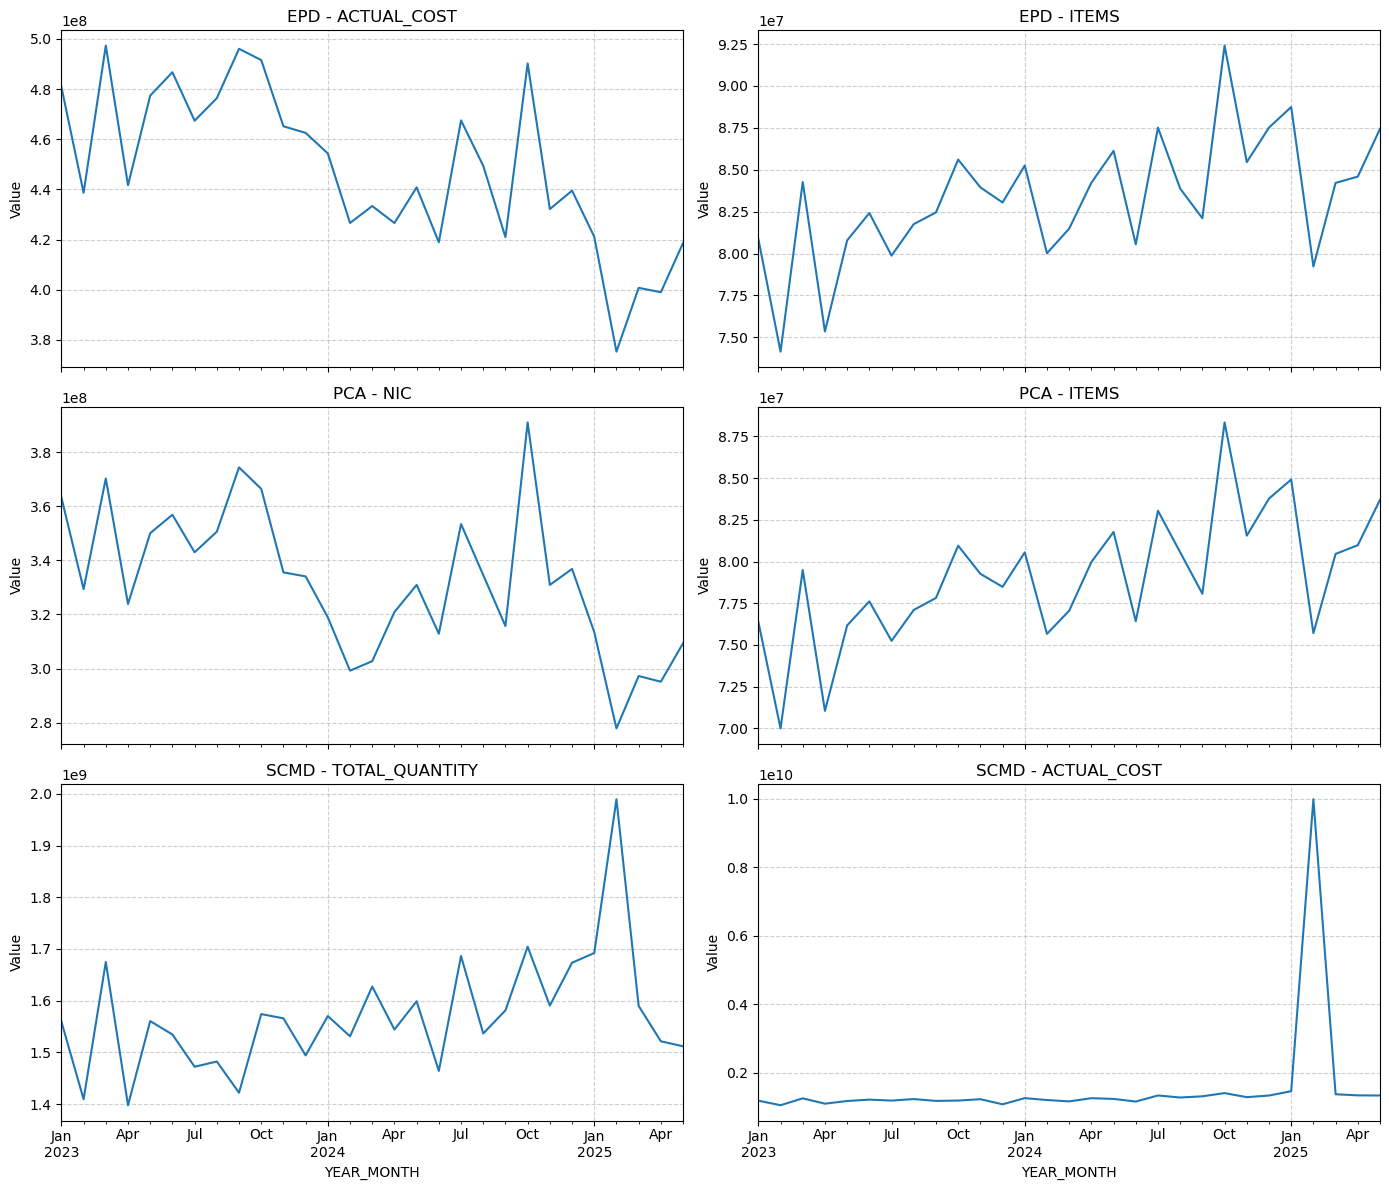

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Paths
BASE = Path("/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData")
EPD_PATH = BASE / "EPD_Processed_Data_clean.csv"
PCA_PATH = BASE / "PCA_Processed_Data_clean.csv"
SCMD_PATH = BASE / "SCMD_Processed_Data_clean.csv"

# Load
epd  = pd.read_csv(EPD_PATH, dtype=str, low_memory=False)
pca  = pd.read_csv(PCA_PATH, dtype=str, low_memory=False)
scmd = pd.read_csv(SCMD_PATH, dtype=str, low_memory=False)

# Convert YEAR_MONTH to datetime
for df in [epd, pca, scmd]:
    df["YEAR_MONTH"] = pd.to_datetime(df["YEAR_MONTH"], format="%Y%m")

# Convert numeric fields
epd["ACTUAL_COST"] = pd.to_numeric(epd["ACTUAL_COST"], errors="coerce")
epd["ITEMS"] = pd.to_numeric(epd["ITEMS"], errors="coerce")

pca["NIC"] = pd.to_numeric(pca["NIC"], errors="coerce")
pca["ITEMS"] = pd.to_numeric(pca["ITEMS"], errors="coerce")

scmd["TOTAL_QUANTITY"] = pd.to_numeric(scmd["TOTAL_QUANTITY"], errors="coerce")
scmd["ACTUAL_COST"] = pd.to_numeric(scmd["ACTUAL_COST"], errors="coerce")

# Aggregate by YEAR_MONTH
epd_trend  = epd.groupby("YEAR_MONTH")[["ACTUAL_COST","ITEMS"]].sum()
pca_trend  = pca.groupby("YEAR_MONTH")[["NIC","ITEMS"]].sum()
scmd_trend = scmd.groupby("YEAR_MONTH")[["TOTAL_QUANTITY","ACTUAL_COST"]].sum()

# --- Plot ---
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True)

# EPD
epd_trend["ACTUAL_COST"].plot(ax=axes[0,0], title="EPD - ACTUAL_COST", legend=False)
epd_trend["ITEMS"].plot(ax=axes[0,1], title="EPD - ITEMS", legend=False)

# PCA
pca_trend["NIC"].plot(ax=axes[1,0], title="PCA - NIC", legend=False)
pca_trend["ITEMS"].plot(ax=axes[1,1], title="PCA - ITEMS", legend=False)

# SCMD
scmd_trend["TOTAL_QUANTITY"].plot(ax=axes[2,0], title="SCMD - TOTAL_QUANTITY", legend=False)
scmd_trend["ACTUAL_COST"].plot(ax=axes[2,1], title="SCMD - ACTUAL_COST", legend=False)

# Formatting
for ax in axes.flat:
    ax.set_ylabel("Value")
    ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [173]:
import pandas as pd
from pathlib import Path

# Paths
BASE = Path("/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData")
SCMD_PATH = BASE / "SCMD_Processed_Data_clean.csv"
MAP_PATH  = BASE / "VMP_AMP_to_BNF_Mapped_clean.csv"

# Load data
scmd  = pd.read_csv(SCMD_PATH, dtype=str, low_memory=False)
mapdf = pd.read_csv(MAP_PATH, dtype=str, low_memory=False)

# Convert numeric fields
scmd["ACTUAL_COST"] = pd.to_numeric(scmd["ACTUAL_COST"], errors="coerce")
scmd["TOTAL_QUANTITY"] = pd.to_numeric(scmd["TOTAL_QUANTITY"], errors="coerce")

# Filter for Feb 2025
scmd_feb = scmd[scmd["YEAR_MONTH"] == "202502"]

# Merge with MAP to get BNF classification and product names
merged = scmd_feb.merge(mapdf, on="VMP_AMP", how="left")

# ---- Step 1: Check cost by BNF Chapter ----
chapter_cost = (
    merged.groupby("BNF_CHAPTER")["ACTUAL_COST"]
    .sum()
    .sort_values(ascending=False)
)
print("\n=== Total Cost by BNF Chapter (Feb 2025) ===")
print(chapter_cost)

# ---- Step 2: Within top chapter, find top 10 drugs ----
top_chapter = chapter_cost.index[0]
top_drugs = (
    merged[merged["BNF_CHAPTER"] == top_chapter]
    .groupby(["VMP_AMP", "BNF_PARAGRAPH", "BNF_SECTION", "BNF_PRESENTATION"])["ACTUAL_COST"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

print(f"\n=== Top 10 Drugs in Chapter {top_chapter} (Feb 2025) ===")
print(top_drugs)


=== Total Cost by BNF Chapter (Feb 2025) ===
BNF_CHAPTER
Malignant Disease and Immunosuppression                9.189089e+09
Musculoskeletal and Joint Diseases                     1.978647e+08
Infections                                             1.711758e+08
Nutrition and Blood                                    9.557756e+07
Respiratory System                                     7.202133e+07
Cardiovascular System                                  4.312292e+07
Gastro-Intestinal System                               4.023838e+07
Endocrine System                                       3.973988e+07
Skin                                                   3.885916e+07
Central Nervous System                                 3.882159e+07
Immunological Products and Vaccines                    3.261447e+07
Eye                                                    1.380170e+07
Anaesthesia                                            1.213656e+07
Obstetrics, Gynaecology and Urinary-Tract Disorders    3.2

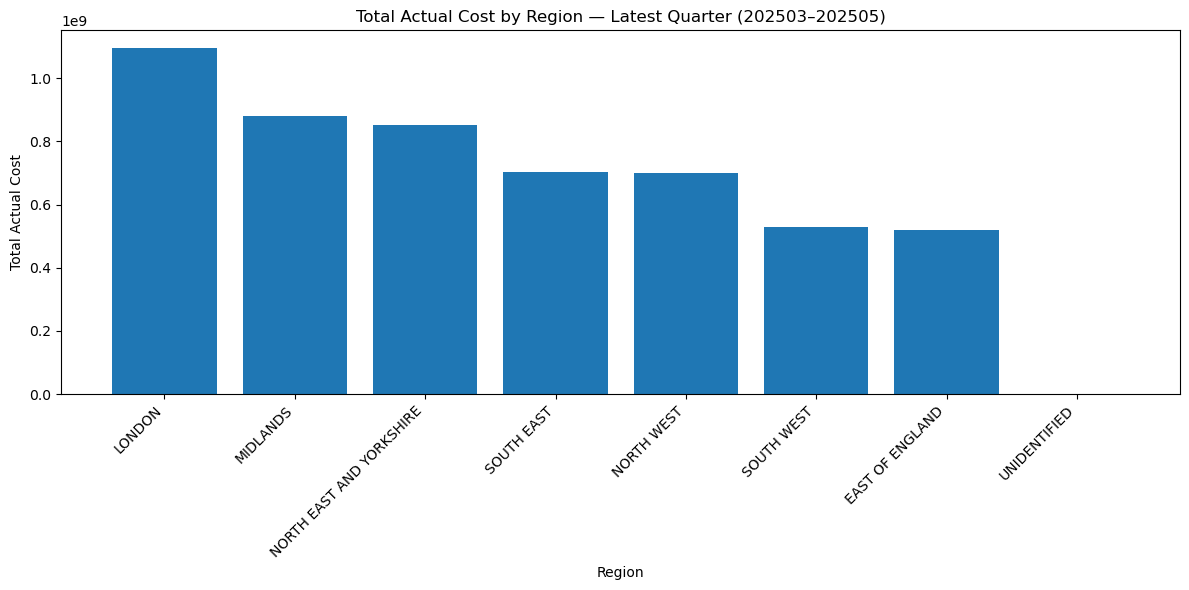

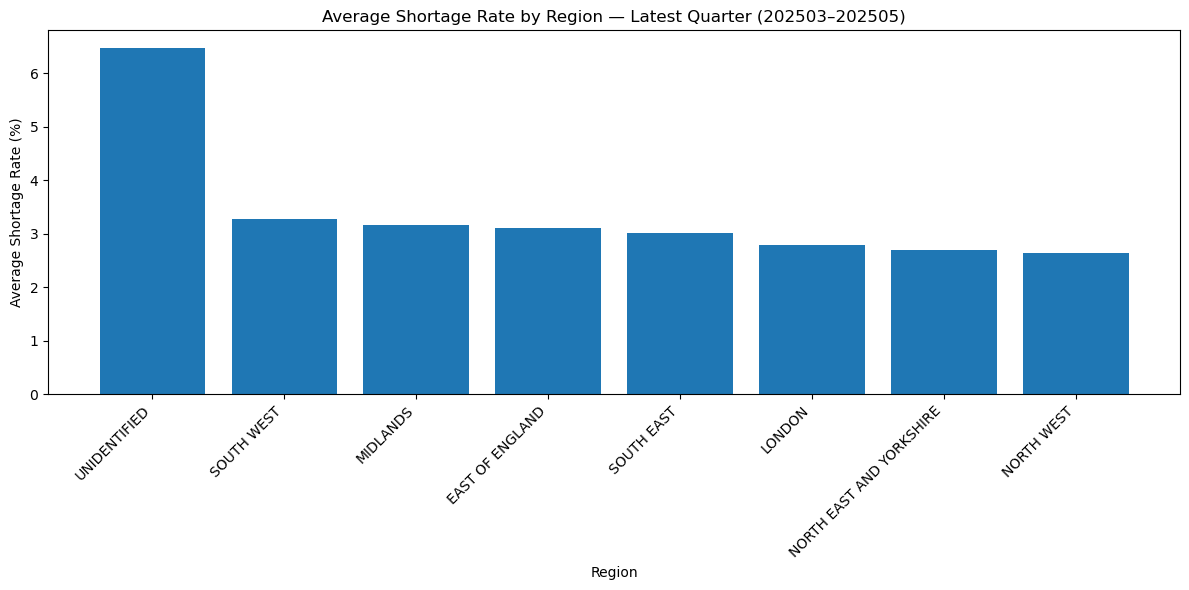

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Paths
BASE = Path("/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData")
EPD_PATH = BASE / "EPD_Processed_Data_clean.csv"
SCMD_PATH = BASE / "SCMD_Processed_Data_clean.csv"

# Load
epd  = pd.read_csv(EPD_PATH, dtype=str, low_memory=False)
scmd = pd.read_csv(SCMD_PATH, dtype=str, low_memory=False)

# Convert numeric + date
for df in [epd, scmd]:
    df["YEAR_MONTH"] = pd.to_numeric(df["YEAR_MONTH"], errors="coerce")
    df["ACTUAL_COST"] = pd.to_numeric(df["ACTUAL_COST"], errors="coerce")
    if "GenericShortage" in df.columns:
        df["GenericShortage"] = pd.to_numeric(df["GenericShortage"], errors="coerce")

# Filter for latest quarter
latest_quarter = [202503, 202504, 202505]
epd_q = epd[epd["YEAR_MONTH"].isin(latest_quarter)]
scmd_q = scmd[scmd["YEAR_MONTH"].isin(latest_quarter)]

# ---- 1) Total Actual Cost by Region (EPD+SCMD) ----
cost_by_region = (
    pd.concat([epd_q[["REGION_NAME","ACTUAL_COST"]],
               scmd_q[["REGION_NAME","ACTUAL_COST"]]])
    .groupby("REGION_NAME", as_index=False)["ACTUAL_COST"].sum()
    .sort_values("ACTUAL_COST", ascending=False)
)

plt.figure(figsize=(12,6))
plt.bar(cost_by_region["REGION_NAME"], cost_by_region["ACTUAL_COST"])
plt.title("Total Actual Cost by Region — Latest Quarter (202503–202505)")
plt.xlabel("Region")
plt.ylabel("Total Actual Cost")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---- 2) Average Shortage Rate by Region (EPD+SCMD) ----
shortage_cols_exist = ("GenericShortage" in epd_q.columns) and ("GenericShortage" in scmd_q.columns)
if shortage_cols_exist:
    shortage_by_region = (
        pd.concat([epd_q[["REGION_NAME","GenericShortage"]],
                   scmd_q[["REGION_NAME","GenericShortage"]]])
        .groupby("REGION_NAME", as_index=False)["GenericShortage"].mean()
        .sort_values("GenericShortage", ascending=False)
    )

    plt.figure(figsize=(12,6))
    plt.bar(shortage_by_region["REGION_NAME"], shortage_by_region["GenericShortage"] * 100)
    plt.title("Average Shortage Rate by Region — Latest Quarter (202503–202505)")
    plt.xlabel("Region")
    plt.ylabel("Average Shortage Rate (%)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'GenericShortage' not found in one or both datasets. Skipping shortage-rate chart.")

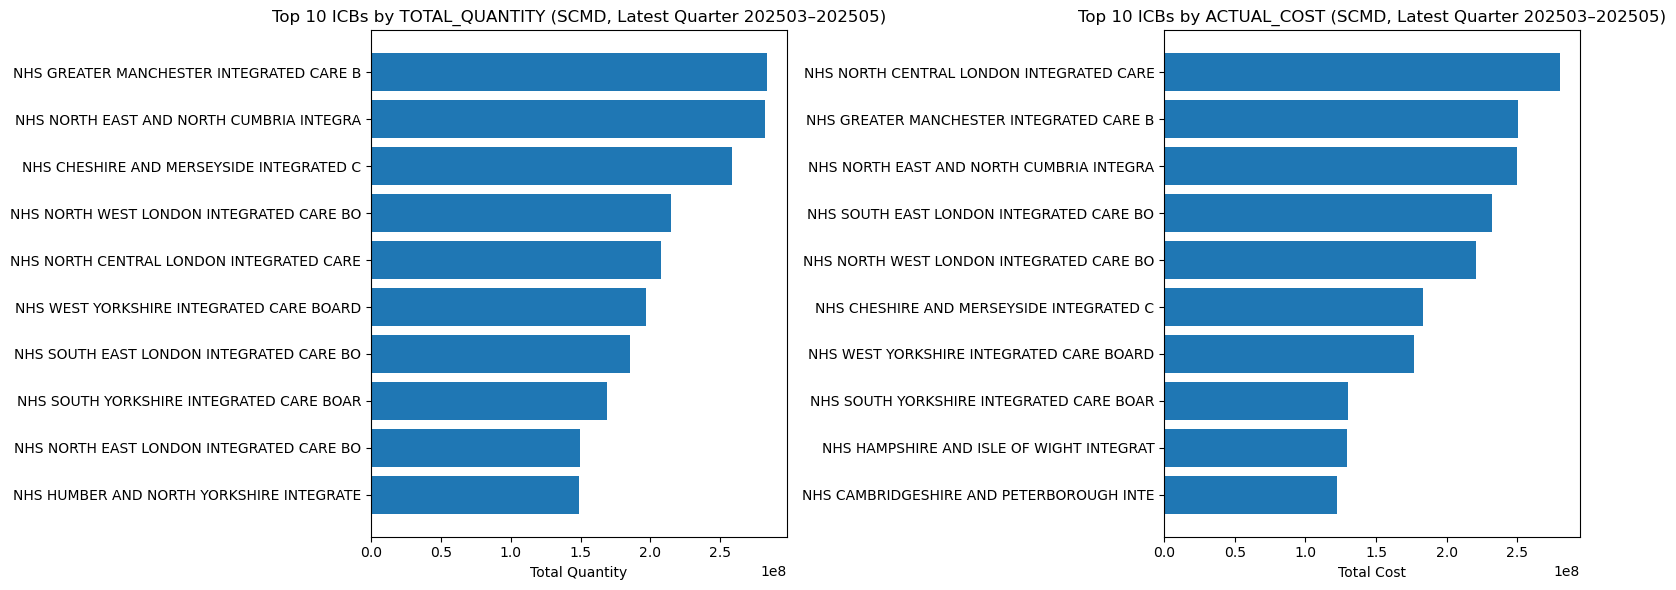

In [181]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Paths
BASE = Path("/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData")
SCMD_PATH = BASE / "SCMD_Processed_Data_clean.csv"

# Load
scmd = pd.read_csv(SCMD_PATH, dtype=str, low_memory=False)

# Convert fields
scmd["YEAR_MONTH"] = pd.to_numeric(scmd["YEAR_MONTH"], errors="coerce")
scmd["TOTAL_QUANTITY"] = pd.to_numeric(scmd["TOTAL_QUANTITY"], errors="coerce")
scmd["ACTUAL_COST"] = pd.to_numeric(scmd["ACTUAL_COST"], errors="coerce")

# Filter for latest quarter
latest_quarter = [202503, 202504, 202505]
scmd_q = scmd[scmd["YEAR_MONTH"].isin(latest_quarter)]

# Group by ICB
icb_summary = scmd_q.groupby("ICB_NAME", as_index=False).agg({
    "TOTAL_QUANTITY": "sum",
    "ACTUAL_COST": "sum"
})

# Top 10 by Quantity
top10_quantity = icb_summary.nlargest(10, "TOTAL_QUANTITY")

# Top 10 by Cost
top10_cost = icb_summary.nlargest(10, "ACTUAL_COST")

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left chart: Quantity
axes[0].barh(top10_quantity["ICB_NAME"], top10_quantity["TOTAL_QUANTITY"])
axes[0].set_title("Top 10 ICBs by TOTAL_QUANTITY (SCMD, Latest Quarter 202503–202505)")
axes[0].invert_yaxis()
axes[0].set_xlabel("Total Quantity")

# Right chart: Cost
axes[1].barh(top10_cost["ICB_NAME"], top10_cost["ACTUAL_COST"])
axes[1].set_title("Top 10 ICBs by ACTUAL_COST (SCMD, Latest Quarter 202503–202505)")
axes[1].invert_yaxis()
axes[1].set_xlabel("Total Cost")

plt.tight_layout()
plt.show()

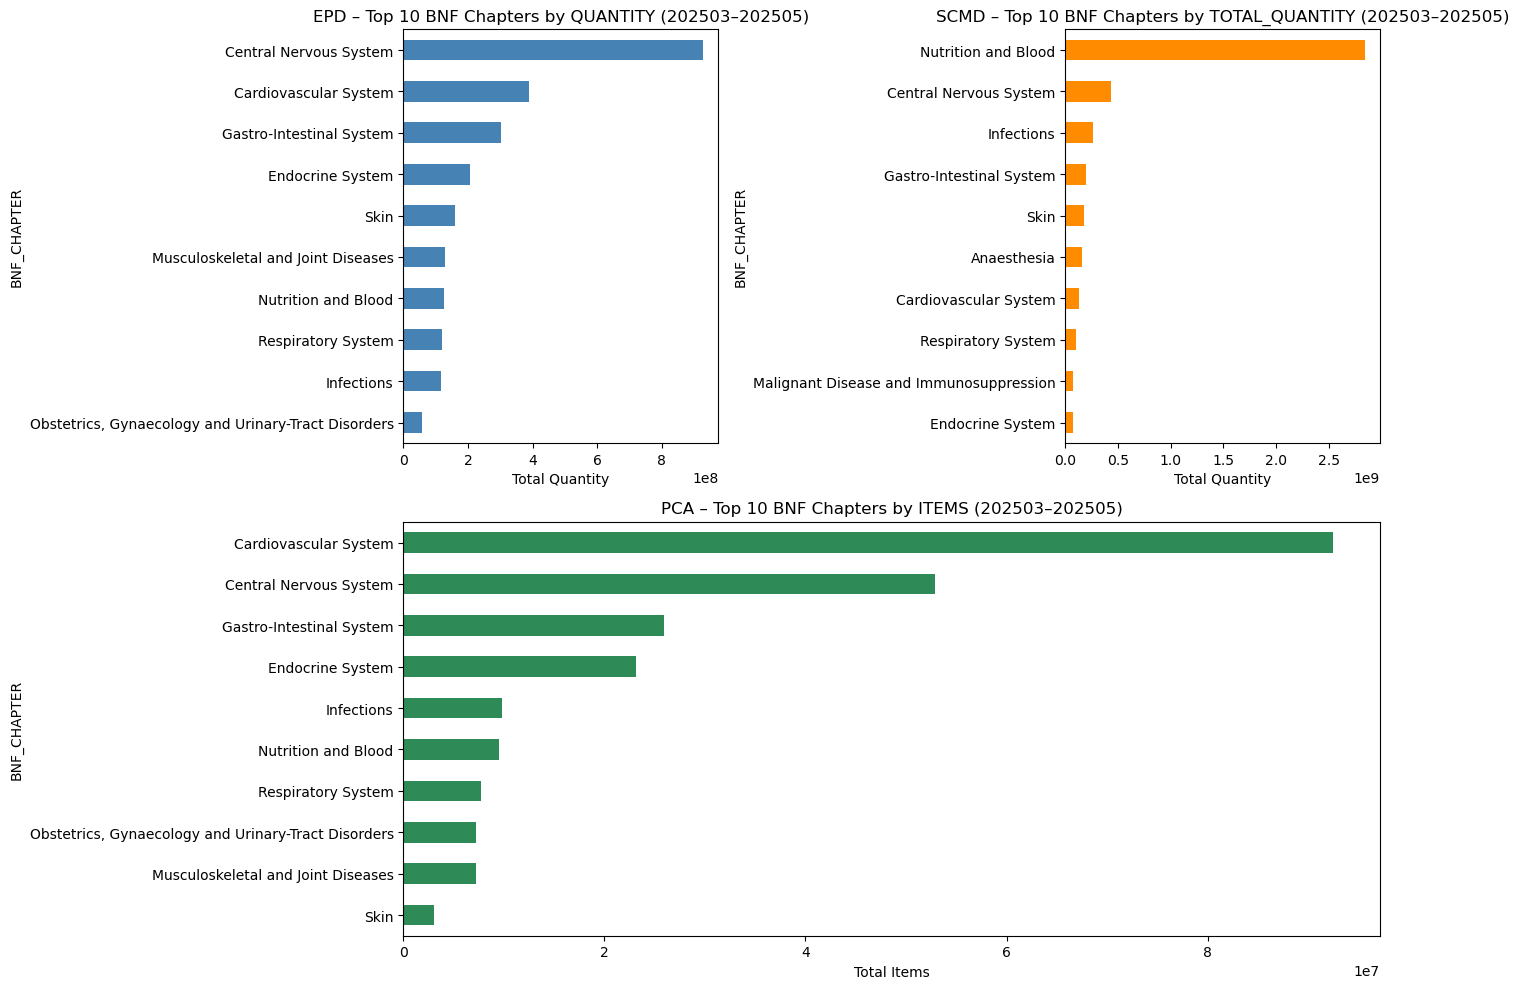

In [183]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Paths
BASE = Path("/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData")
EPD_PATH  = BASE / "EPD_Processed_Data_clean.csv"
SCMD_PATH = BASE / "SCMD_Processed_Data_clean.csv"
PCA_PATH  = BASE / "PCA_Processed_Data_clean.csv"
MAP_PATH  = BASE / "VMP_AMP_to_BNF_Mapped_clean.csv"

# Load datasets
epd  = pd.read_csv(EPD_PATH, dtype=str, low_memory=False)
scmd = pd.read_csv(SCMD_PATH, dtype=str, low_memory=False)
pca  = pd.read_csv(PCA_PATH, dtype=str, low_memory=False)
mapdf = pd.read_csv(MAP_PATH, dtype=str, low_memory=False)

# Convert fields
for df in [epd, scmd, pca]:
    df["YEAR_MONTH"] = pd.to_numeric(df["YEAR_MONTH"], errors="coerce")
    for col in ["QUANTITY","ITEMS","TOTAL_QUANTITY"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

# Filter for latest quarter
latest_quarter = [202503, 202504, 202505]
epd_q  = epd[epd["YEAR_MONTH"].isin(latest_quarter)]
scmd_q = scmd[scmd["YEAR_MONTH"].isin(latest_quarter)]
pca_q  = pca[pca["YEAR_MONTH"].isin(latest_quarter)]

# Merge with MAP for chapters
epd_q  = epd_q.merge(mapdf[["VMP_AMP","BNF_CHAPTER"]], on="VMP_AMP", how="left")
scmd_q = scmd_q.merge(mapdf[["VMP_AMP","BNF_CHAPTER"]], on="VMP_AMP", how="left")
pca_q  = pca_q.merge(mapdf[["VMP_AMP","BNF_CHAPTER"]], on="VMP_AMP", how="left")

# Aggregate Top 10
epd_top10  = epd_q.groupby("BNF_CHAPTER")["QUANTITY"].sum().nlargest(10)
scmd_top10 = scmd_q.groupby("BNF_CHAPTER")["TOTAL_QUANTITY"].sum().nlargest(10)
pca_top10  = pca_q.groupby("BNF_CHAPTER")["ITEMS"].sum().nlargest(10)

# --- Plot ---
fig = plt.figure(figsize=(14, 10))

# Top left: EPD
ax1 = plt.subplot2grid((2,2), (0,0))
epd_top10.plot(kind="barh", ax=ax1, color="steelblue")
ax1.set_title("EPD – Top 10 BNF Chapters by QUANTITY (202503–202505)")
ax1.set_xlabel("Total Quantity")
ax1.invert_yaxis()

# Top right: SCMD
ax2 = plt.subplot2grid((2,2), (0,1))
scmd_top10.plot(kind="barh", ax=ax2, color="darkorange")
ax2.set_title("SCMD – Top 10 BNF Chapters by TOTAL_QUANTITY (202503–202505)")
ax2.set_xlabel("Total Quantity")
ax2.invert_yaxis()

# Bottom center: PCA (span full width)
ax3 = plt.subplot2grid((2,2), (1,0), colspan=2)
pca_top10.plot(kind="barh", ax=ax3, color="seagreen")
ax3.set_title("PCA – Top 10 BNF Chapters by ITEMS (202503–202505)")
ax3.set_xlabel("Total Items")
ax3.invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# --- Shortage statistics ---
shortage_stats = {
    'total_shortage_instances': df['GenericShortage'].sum(),
    'shortage_rate': df['GenericShortage'].mean() * 100,
    'products_affected': df[df['GenericShortage'] == 1]['VMP_AMP'].nunique(),
    'total_cost_impact': df[df['GenericShortage'] == 1]['NIC'].sum()
}

print("Shortage Statistics:")
for key, value in shortage_stats.items():
    if 'cost' in key:
        print(f"  {key}: £{value:,.2f}")
    elif 'rate' in key:
        print(f"  {key}: {value:.2f}%")
    else:
        print(f"  {key}: {value:,}")

# --- Top 20 products by shortage frequency ---
product_shortage = df.groupby('VMP_AMP').agg({
    'GenericShortage': ['sum', 'mean'],
    'NIC': 'sum'
}).round(2)
product_shortage.columns = ['shortage_count', 'shortage_rate', 'total_nic']
product_shortage = product_shortage[product_shortage['shortage_count'] > 0]
product_shortage = product_shortage.sort_values('shortage_count', ascending=False)

print("\nTop 20 Products by Shortage Frequency:")
print(product_shortage.head(20))

# --- Trend analysis for top 5 products ---
top5_products = product_shortage.head(5).index.tolist()

# Ensure YEAR_MONTH is numeric
df["YEAR_MONTH"] = pd.to_numeric(df["YEAR_MONTH"], errors="coerce")

fig, axes = plt.subplots(len(top5_products), 1, figsize=(12, 15), sharex=True)

for i, prod in enumerate(top5_products):
    sub = df[df["VMP_AMP"] == prod]

    # Group by year-month and GC status
    sub_grouped = sub.groupby(["YEAR_MONTH","GenericShortage"])["NIC"].sum().reset_index()

    # Pivot so we get two series: NIC when in GC (1) and not in GC (0)
    pivot = sub_grouped.pivot(index="YEAR_MONTH", columns="GenericShortage", values="NIC").fillna(0)
    pivot.columns = ["Not in GC", "In GC"] if 0 in pivot.columns and 1 in pivot.columns else pivot.columns

    # Plot
    pivot.plot(ax=axes[i], marker="o")
    axes[i].set_title(f"NIC Trend for {prod} (GC vs Non-GC)")
    axes[i].set_ylabel("Total NIC (£)")
    axes[i].grid(True)

plt.xlabel("Year-Month")
plt.tight_layout()
plt.show()

Top 10 BNF_PRESENTATION by shortage count (EPD):
1. Clarithromycin 250mg/5ml oral suspension
2. Mometasone 0.1% ointment
3. Lofepramine 70mg tablets
4. Clarithromycin 125mg/5ml oral suspension
5. Tacrolimus 0.1% ointment
6. Methylphenidate 10mg tablets
7. Oxycodone 5mg/5ml oral solution sugar free
8. Mycophenolate mofetil 500mg tablets
9. Mometasone 0.1% cream
10. Quinine sulfate 200mg tablets


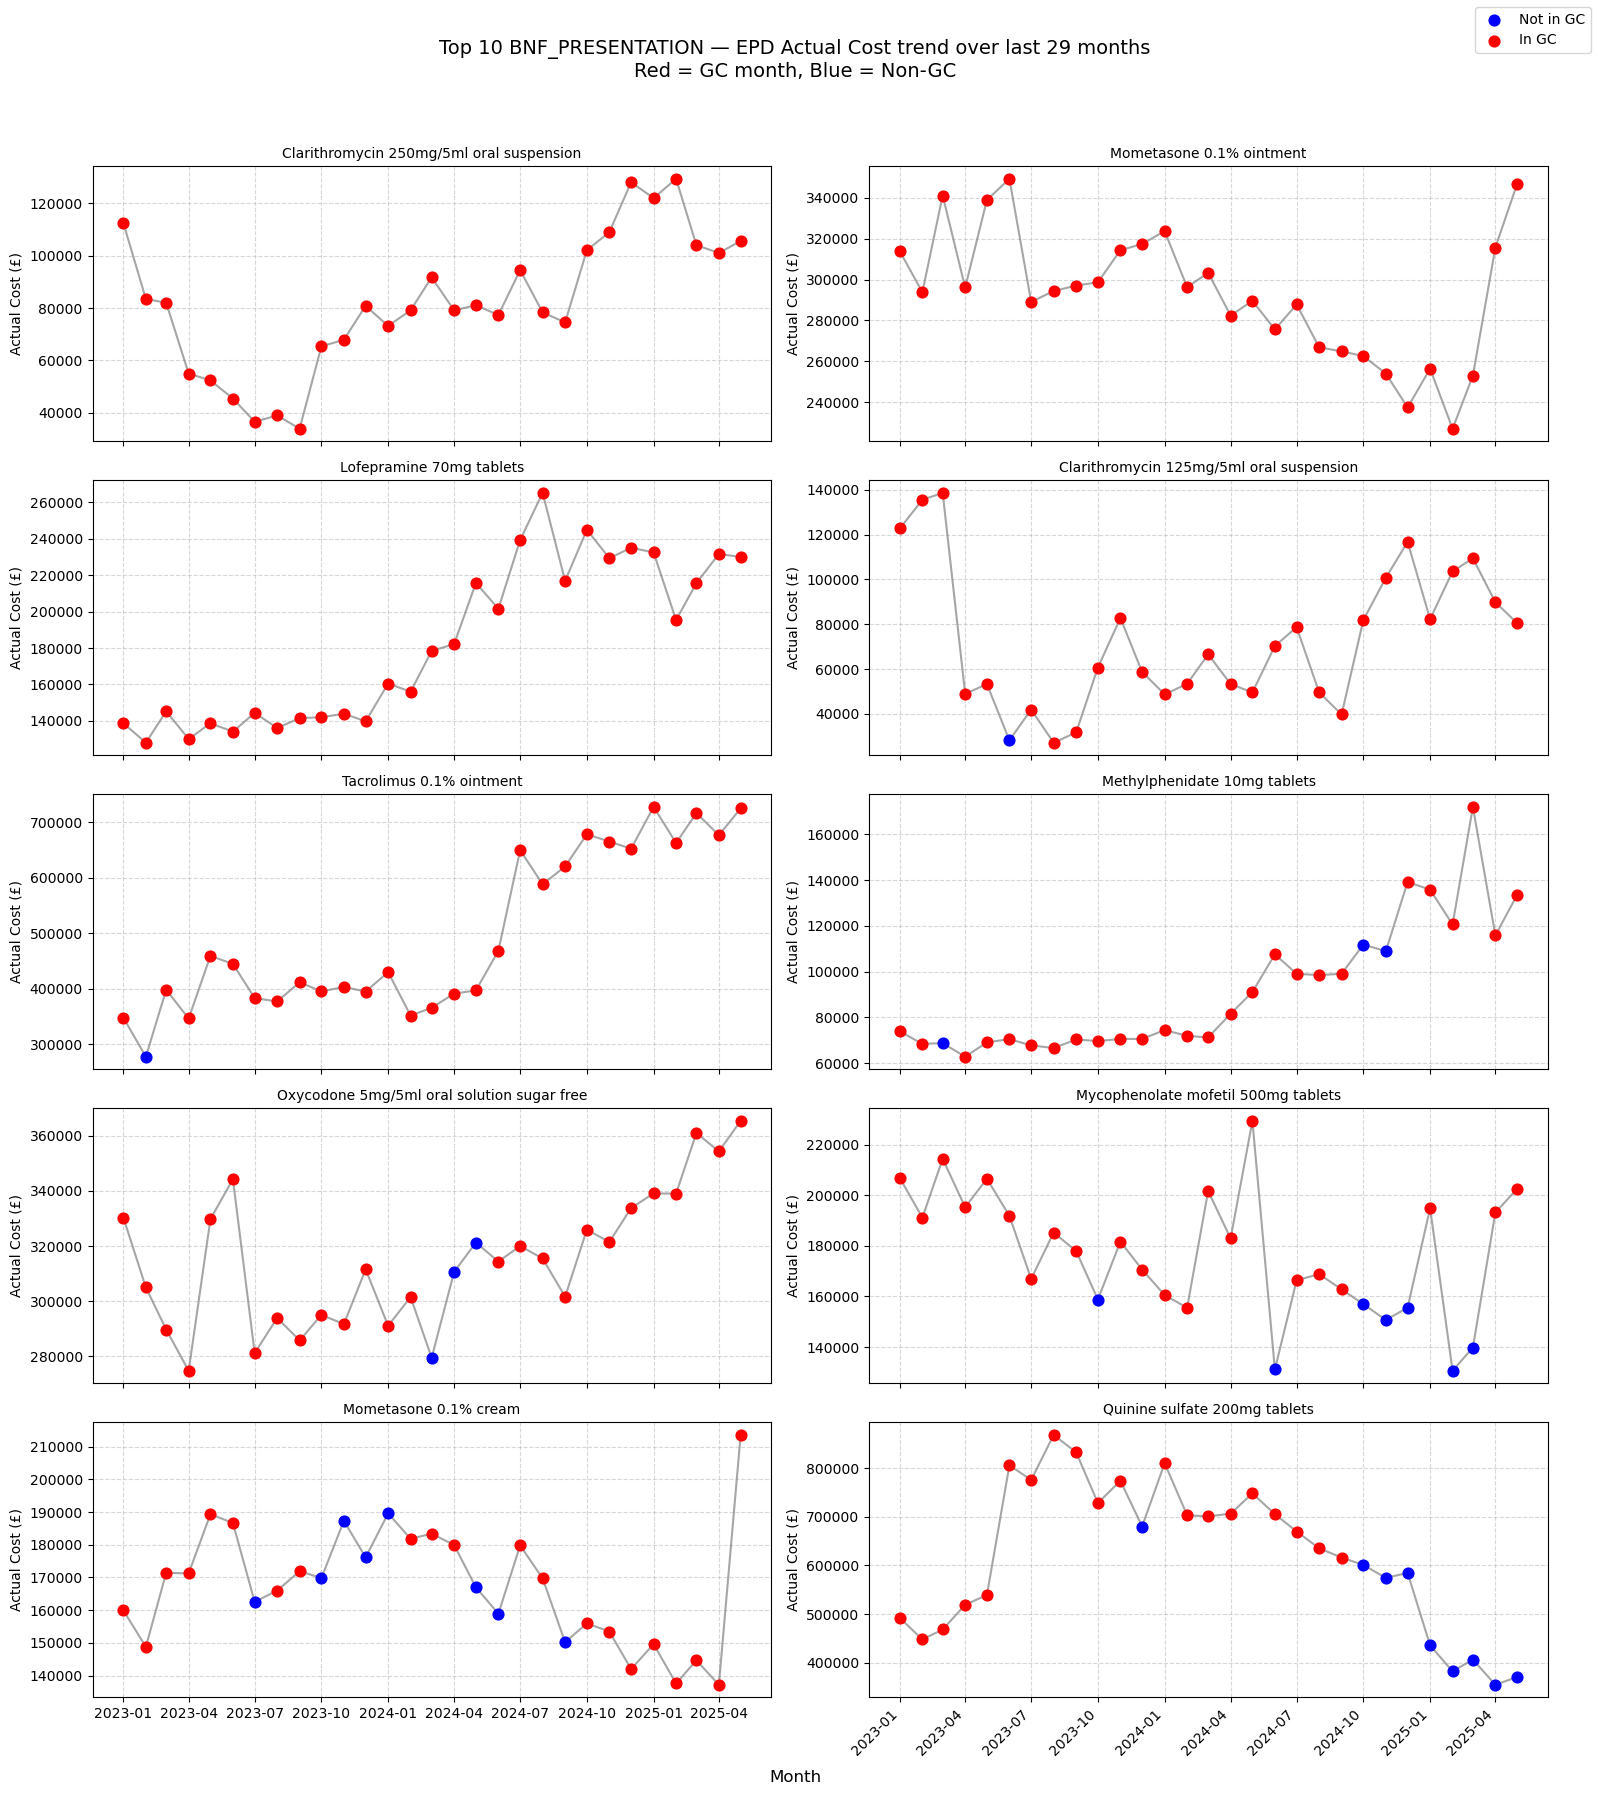

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- Paths ----------
BASE = Path("/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData")
EPD_PATH = BASE / "EPD_Processed_Data_clean.csv"
# Use a MAP that includes BNF_PRESENTATION
MAP_PATH = BASE / "VMP_AMP_to_BNF_Mapped.csv"   # or a clean file if it still has BNF_PRESENTATION

# ---------- Load ----------
epd   = pd.read_csv(EPD_PATH, dtype=str, low_memory=False)
mapdf = pd.read_csv(MAP_PATH, dtype=str, low_memory=False)

# ---------- Ensure required MAP columns ----------
need_cols = {"VMP_AMP", "BNF_PRESENTATION"}
missing = need_cols - set(mapdf.columns)
if missing:
    raise ValueError(f"MAP is missing columns: {missing}. Use a MAP file that contains BNF_PRESENTATION.")

# ---------- Merge EPD with MAP to get BNF_PRESENTATION ----------
epd = epd.merge(mapdf[["VMP_AMP", "BNF_PRESENTATION"]], on="VMP_AMP", how="left")

# ---------- Coerce types ----------
epd["YEAR_MONTH"] = pd.to_numeric(epd["YEAR_MONTH"], errors="coerce")
epd["ACTUAL_COST"] = pd.to_numeric(epd.get("ACTUAL_COST", 0), errors="coerce").fillna(0)
# If your column name differs (e.g., 'GC' or 'IsShortage'), change here:
epd["GenericShortage"] = pd.to_numeric(epd.get("GenericShortage", 0), errors="coerce").fillna(0).astype(int)

# Monthly datetime for alignment on the x-axis
epd["YM"] = pd.to_datetime(epd["YEAR_MONTH"].astype("Int64").astype(str), format="%Y%m", errors="coerce")

# ---------- Last 29 months present in EPD ----------
months_sorted = pd.Index(sorted(epd["YM"].dropna().unique()))
last_29 = months_sorted[-29:] if len(months_sorted) > 29 else months_sorted

# ---------- Top 10 BNF_PRESENTATION by shortage frequency in EPD ----------
top10 = (
    epd.loc[epd["GenericShortage"] == 1, ["BNF_PRESENTATION", "GenericShortage"]]
       .groupby("BNF_PRESENTATION")["GenericShortage"].sum()
       .sort_values(ascending=False)
       .head(10)
       .index.tolist()
)

print("Top 10 BNF_PRESENTATION by shortage count (EPD):")
for i, t in enumerate(top10, 1):
    print(f"{i}. {t}")

# ---------- Plot: 5×2 grid ----------
rows, cols = 5, 2
fig, axes = plt.subplots(rows, cols, figsize=(16, 18), sharex=True)
axes = axes.flatten()

for ax_idx, pres in enumerate(top10):
    ax = axes[ax_idx]
    sub = epd[epd["BNF_PRESENTATION"] == pres]

    # Monthly ACTUAL_COST and shortage flag aligned to last_29 months
    cost_monthly = (
        sub.groupby("YM")["ACTUAL_COST"].sum()
           .reindex(last_29)
           .fillna(0)
    )
    shortage_flag = (
        sub.groupby("YM")["GenericShortage"].max()
           .reindex(last_29)
           .fillna(0).astype(int)
    )

    x = cost_monthly.index
    y = cost_monthly.values
    mask = shortage_flag.values.astype(bool)

    # Gray connecting line for trend
    ax.plot(x, y, color="gray", linewidth=1.5, alpha=0.7)

    # Blue dots = not in GC; Red dots = in GC
    ax.scatter(x[~mask], y[~mask], s=60, color="blue", label="Not in GC", zorder=3)
    ax.scatter(x[mask],  y[mask],  s=60, color="red",  label="In GC",   zorder=3)

    ax.set_title(pres, fontsize=10)
    ax.set_ylabel("Actual Cost (£)")
    ax.grid(True, linestyle="--", alpha=0.5)

# Hide unused subplots if <10 presentations
for k in range(len(top10), rows*cols):
    fig.delaxes(axes[k])

# X-axis formatting
for tick in axes[-1].get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha("right")

fig.suptitle("Top 10 BNF_PRESENTATION — EPD Actual Cost trend over last 29 months\nRed = GC month, Blue = Non-GC", fontsize=14)
fig.supxlabel("Month")

# Single legend
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    if h and l:
        handles, labels = h, l
        break
if handles:
    fig.legend(handles, labels, loc="upper right")

plt.tight_layout(rect=[0, 0, 0.98, 0.96])
plt.show()

In [14]:
import pandas as pd
from pathlib import Path
from statsmodels.tsa.stattools import adfuller, kpss

# ---------- Paths ----------
BASE = Path("/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData")
EPD_PATH  = BASE / "EPD_Processed_Data_clean.csv"
PCA_PATH  = BASE / "PCA_Processed_Data_clean.csv"
SCMD_PATH = BASE / "SCMD_Processed_Data_clean.csv"

# ---------- Load ----------
epd  = pd.read_csv(EPD_PATH, dtype=str, low_memory=False)
pca  = pd.read_csv(PCA_PATH, dtype=str, low_memory=False)
scmd = pd.read_csv(SCMD_PATH, dtype=str, low_memory=False)

# ---------- Convert ----------
for df in [epd, pca, scmd]:
    df["YEAR_MONTH"] = pd.to_numeric(df["YEAR_MONTH"], errors="coerce")
    for col in ["ACTUAL_COST","ITEMS","QUANTITY","TOTAL_QUANTITY","NIC"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

# ---------- Aggregate by YEAR_MONTH ----------
epd_monthly = epd.groupby("YEAR_MONTH")["ACTUAL_COST"].sum()
pca_monthly = pca.groupby("YEAR_MONTH")["NIC"].sum()
scmd_monthly = scmd.groupby("YEAR_MONTH")["ACTUAL_COST"].sum()

series_dict = {
    "EPD (Actual Cost)": epd_monthly,
    "PCA (NIC)": pca_monthly,
    "SCMD (Actual Cost)": scmd_monthly
}

# ---------- Function for stationarity tests ----------
def check_stationarity(series, name):
    series = series.dropna()
    print(f"\n=== {name} ===")
    # ADF Test
    adf_res = adfuller(series)
    print(f"ADF Statistic: {adf_res[0]:.4f}, p-value: {adf_res[1]:.4f}")
    if adf_res[1] < 0.05:
        print(" -> Stationary (reject H0 of unit root)")
    else:
        print(" -> Non-stationary (fail to reject H0)")
    # KPSS Test
    try:
        kpss_res = kpss(series, nlags="auto")
        print(f"KPSS Statistic: {kpss_res[0]:.4f}, p-value: {kpss_res[1]:.4f}")
        if kpss_res[1] < 0.05:
            print(" -> Non-stationary (reject H0 of stationarity)")
        else:
            print(" -> Stationary (fail to reject H0)")
    except:
        print("KPSS test failed (sample too short or constant series)")

# ---------- Run for all three ----------
for name, s in series_dict.items():
    check_stationarity(s, name)


=== EPD (Actual Cost) ===
ADF Statistic: -1.5885, p-value: 0.4894
 -> Non-stationary (fail to reject H0)
KPSS Statistic: 0.5884, p-value: 0.0237
 -> Non-stationary (reject H0 of stationarity)

=== PCA (NIC) ===
ADF Statistic: -2.3244, p-value: 0.1642
 -> Non-stationary (fail to reject H0)
KPSS Statistic: 0.4103, p-value: 0.0727
 -> Stationary (fail to reject H0)

=== SCMD (Actual Cost) ===
ADF Statistic: 3.1085, p-value: 1.0000
 -> Non-stationary (fail to reject H0)
KPSS Statistic: 0.3062, p-value: 0.1000
 -> Stationary (fail to reject H0)


/var/folders/r8/w79dc52s1bvfwsv6pmwb6gxm0000gn/T/ipykernel_73965/284173537.py:47: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series, nlags="auto")


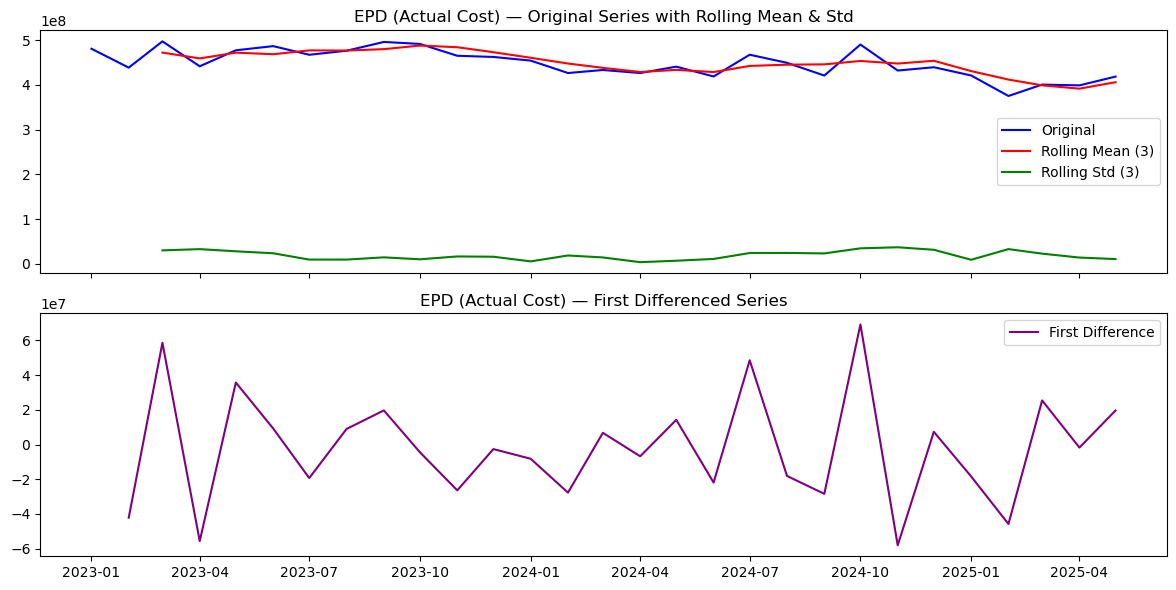

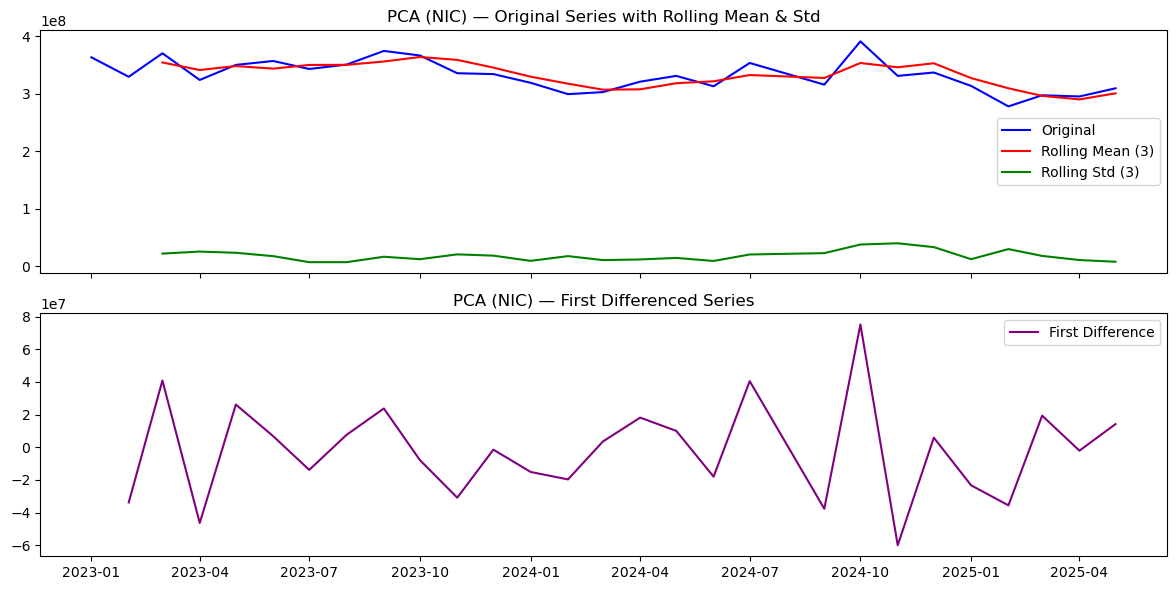

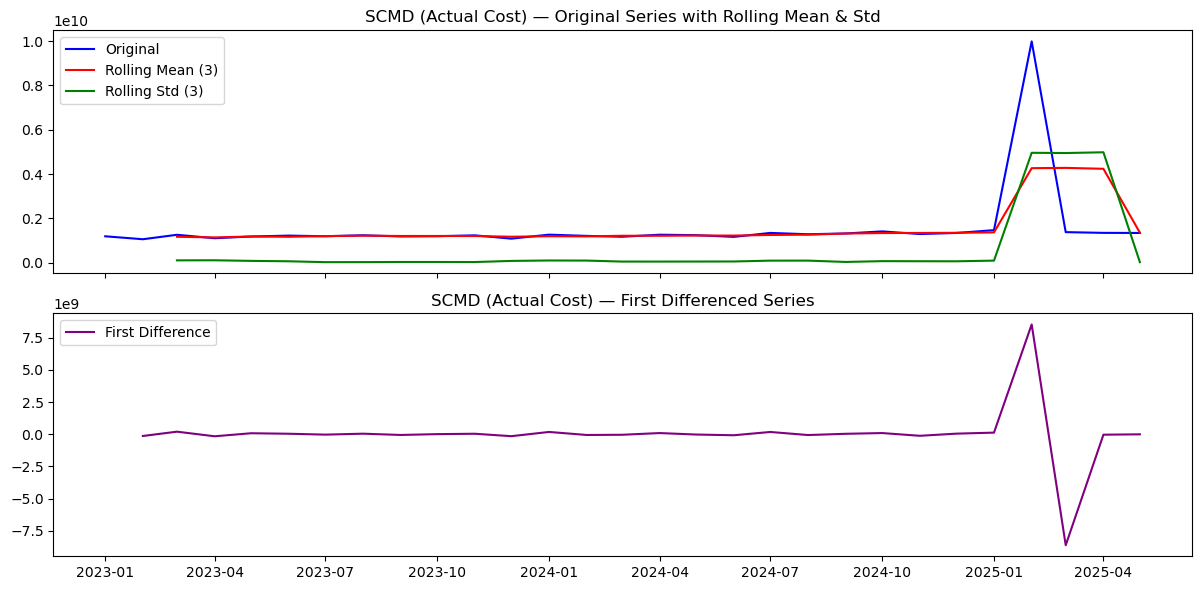

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- Paths ----------
BASE = Path("/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData")
EPD_PATH  = BASE / "EPD_Processed_Data_clean.csv"
PCA_PATH  = BASE / "PCA_Processed_Data_clean.csv"
SCMD_PATH = BASE / "SCMD_Processed_Data_clean.csv"

# ---------- Load ----------
epd  = pd.read_csv(EPD_PATH, dtype=str, low_memory=False)
pca  = pd.read_csv(PCA_PATH, dtype=str, low_memory=False)
scmd = pd.read_csv(SCMD_PATH, dtype=str, low_memory=False)

# ---------- Convert ----------
for df in [epd, pca, scmd]:
    df["YEAR_MONTH"] = pd.to_numeric(df["YEAR_MONTH"], errors="coerce")
    for col in ["ACTUAL_COST","ITEMS","QUANTITY","TOTAL_QUANTITY","NIC"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    # Convert YEAR_MONTH → datetime
    df["YM"] = pd.to_datetime(df["YEAR_MONTH"].astype("Int64").astype(str), format="%Y%m", errors="coerce")

# ---------- Aggregate by YM ----------
epd_monthly  = epd.groupby("YM")["ACTUAL_COST"].sum()
pca_monthly  = pca.groupby("YM")["NIC"].sum()
scmd_monthly = scmd.groupby("YM")["ACTUAL_COST"].sum()

series_dict = {
    "EPD (Actual Cost)": epd_monthly,
    "PCA (NIC)": pca_monthly,
    "SCMD (Actual Cost)": scmd_monthly
}

# ---------- Plot function ----------
def plot_stationarity(series, name):
    s = series.dropna()
    roll_mean = s.rolling(window=3).mean()
    roll_std = s.rolling(window=3).std()
    
    fig, axes = plt.subplots(2, 1, figsize=(12,6), sharex=True)
    
    # Original with rolling stats
    axes[0].plot(s.index, s.values, label="Original", color="blue")
    axes[0].plot(roll_mean.index, roll_mean.values, label="Rolling Mean (3)", color="red")
    axes[0].plot(roll_std.index, roll_std.values, label="Rolling Std (3)", color="green")
    axes[0].set_title(f"{name} — Original Series with Rolling Mean & Std")
    axes[0].legend()
    
    # First difference
    diff = s.diff().dropna()
    axes[1].plot(diff.index, diff.values, label="First Difference", color="purple")
    axes[1].set_title(f"{name} — First Differenced Series")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# ---------- Run for all ----------
for name, s in series_dict.items():
    plot_stationarity(s, name)

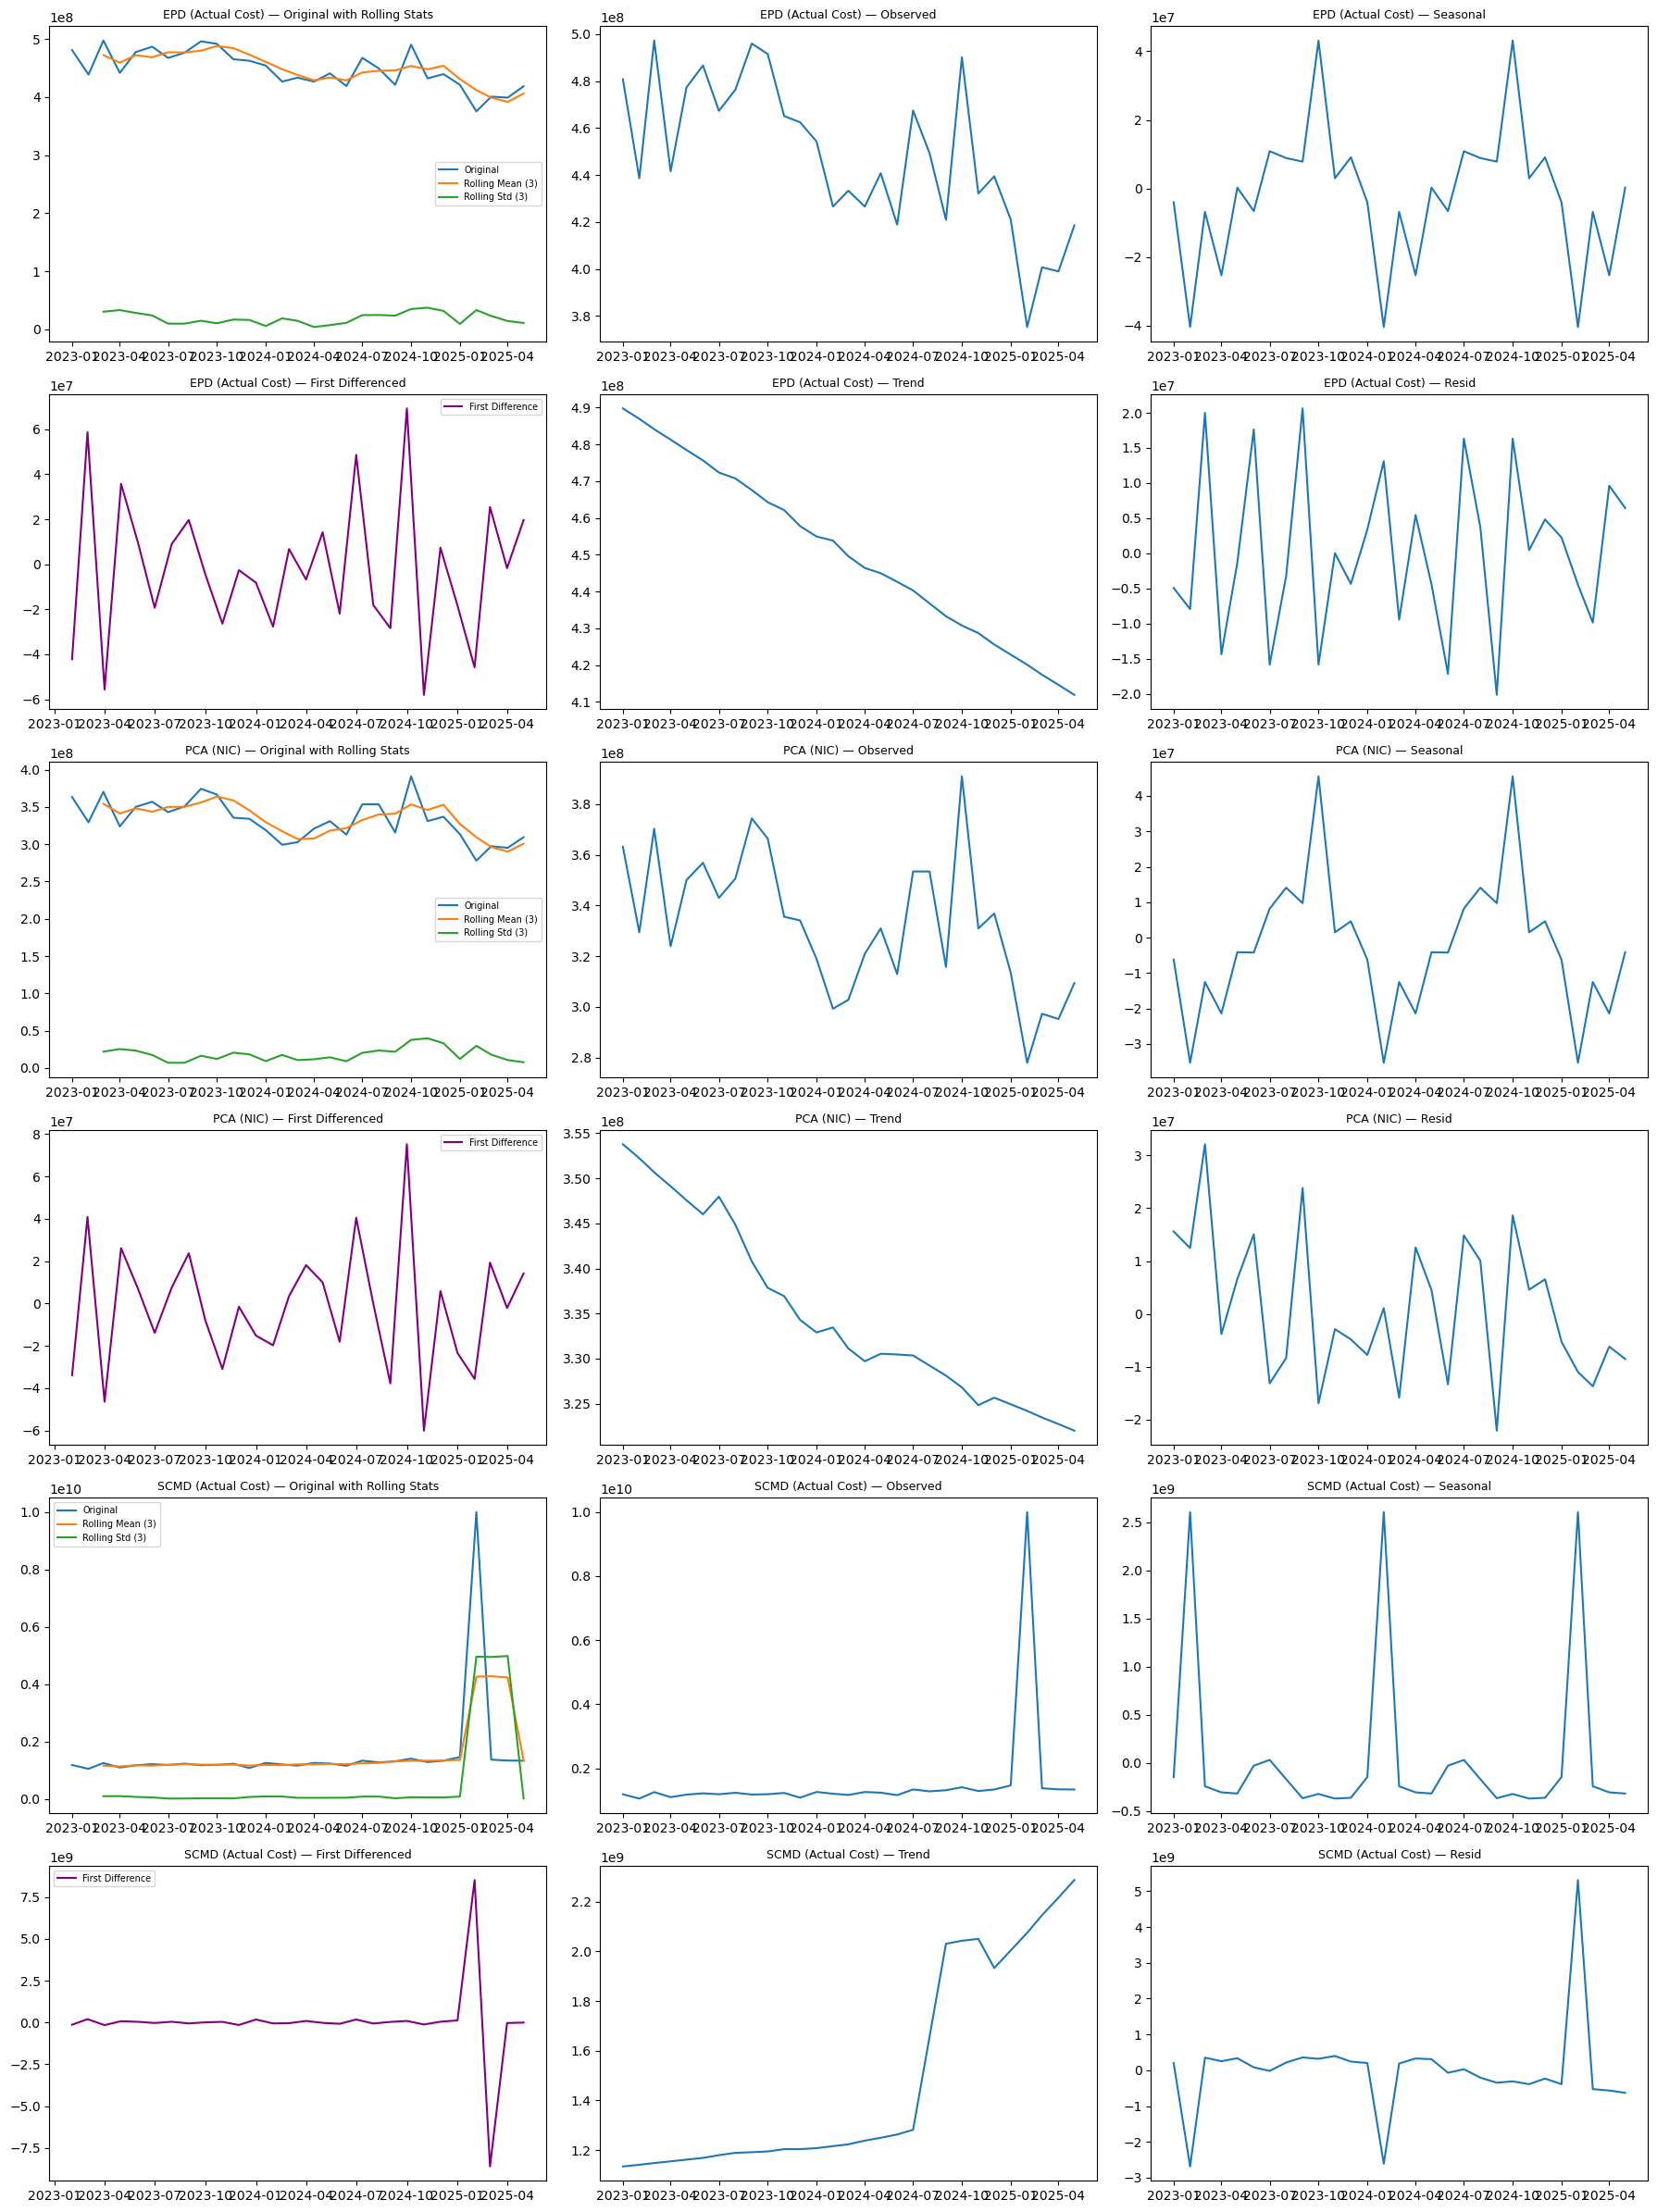

In [28]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

# ---------------- Paths & Load ----------------
BASE = Path("/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData")
EPD_PATH  = BASE / "EPD_Processed_Data_clean.csv"
PCA_PATH  = BASE / "PCA_Processed_Data_clean.csv"
SCMD_PATH = BASE / "SCMD_Processed_Data_clean.csv"

epd  = pd.read_csv(EPD_PATH, dtype=str, low_memory=False)
pca  = pd.read_csv(PCA_PATH, dtype=str, low_memory=False)
scmd = pd.read_csv(SCMD_PATH, dtype=str, low_memory=False)

# ---------------- Basic typing ----------------
for df in [epd, pca, scmd]:
    df["YEAR_MONTH"] = pd.to_numeric(df["YEAR_MONTH"], errors="coerce")
    for col in ["ACTUAL_COST","ITEMS","QUANTITY","TOTAL_QUANTITY","NIC"]:
        if col in df.columns: df[col] = pd.to_numeric(df[col], errors="coerce")
    df["YM"] = pd.to_datetime(df["YEAR_MONTH"].astype("Int64").astype(str), format="%Y%m", errors="coerce")

epd_m  = epd.groupby("YM")["ACTUAL_COST"].sum()
pca_m  = pca.groupby("YM")["NIC"].sum()
scmd_m = scmd.groupby("YM")["ACTUAL_COST"].sum()

series_dict = {
    "EPD (Actual Cost)": epd_m,
    "PCA (NIC)": pca_m,
    "SCMD (Actual Cost)": scmd_m
}

# ---------------- Helpers ----------------
def monthly_complete(s: pd.Series) -> pd.Series:
    s = s.dropna().sort_index()
    if s.empty: return s
    full_idx = pd.date_range(s.index.min(), s.index.max(), freq="MS")
    return s.reindex(full_idx).ffill().bfill()

def plot_stationarity(axs, series, name):
    s = monthly_complete(series)
    roll_mean = s.rolling(3).mean()
    roll_std  = s.rolling(3).std()

    # Original
    axs[0].plot(s.index, s.values, label="Original")
    axs[0].plot(roll_mean.index, roll_mean.values, label="Rolling Mean (3)")
    axs[0].plot(roll_std.index,  roll_std.values,  label="Rolling Std (3)")
    axs[0].set_title(f"{name} — Original with Rolling Stats", fontsize=9)
    axs[0].legend(fontsize=7)

    # Differenced
    diff = s.diff().dropna()
    axs[1].plot(diff.index, diff.values, label="First Difference", color="purple")
    axs[1].set_title(f"{name} — First Differenced", fontsize=9)
    axs[1].legend(fontsize=7)

def decompose_plot(axs, series, name, period=12):
    s = monthly_complete(series)
    if len(s) < 2*period:
        axs[0].text(0.5,0.5,"Not enough data",ha="center",va="center")
        return
    result = seasonal_decompose(s, model="additive", period=period, extrapolate_trend="freq")
    components = [("Observed", result.observed), 
                  ("Trend", result.trend), 
                  ("Seasonal", result.seasonal), 
                  ("Resid", result.resid)]
    for ax, (title, comp) in zip(axs, components):
        ax.plot(comp.index, comp.values)
        ax.set_title(f"{name} — {title}", fontsize=9)

# ---------------- Master 6x3 Grid ----------------
fig, axes = plt.subplots(6, 3, figsize=(18, 24))  # 18 subplots

datasets = list(series_dict.items())
row = 0
for (name, series) in datasets:
    # Row block for each dataset (2 for stationarity + 4 for decomposition = 6 rows per dataset)
    plot_stationarity([axes[row,0], axes[row+1,0]], series, name)
    decompose_plot([axes[row,1], axes[row+1,1], axes[row,2], axes[row+1,2]], series, name)
    row += 2  # move down two rows per dataset

plt.tight_layout()
plt.show()

Pearson correlation between EPD Actual Cost and PCA NIC: 0.9401


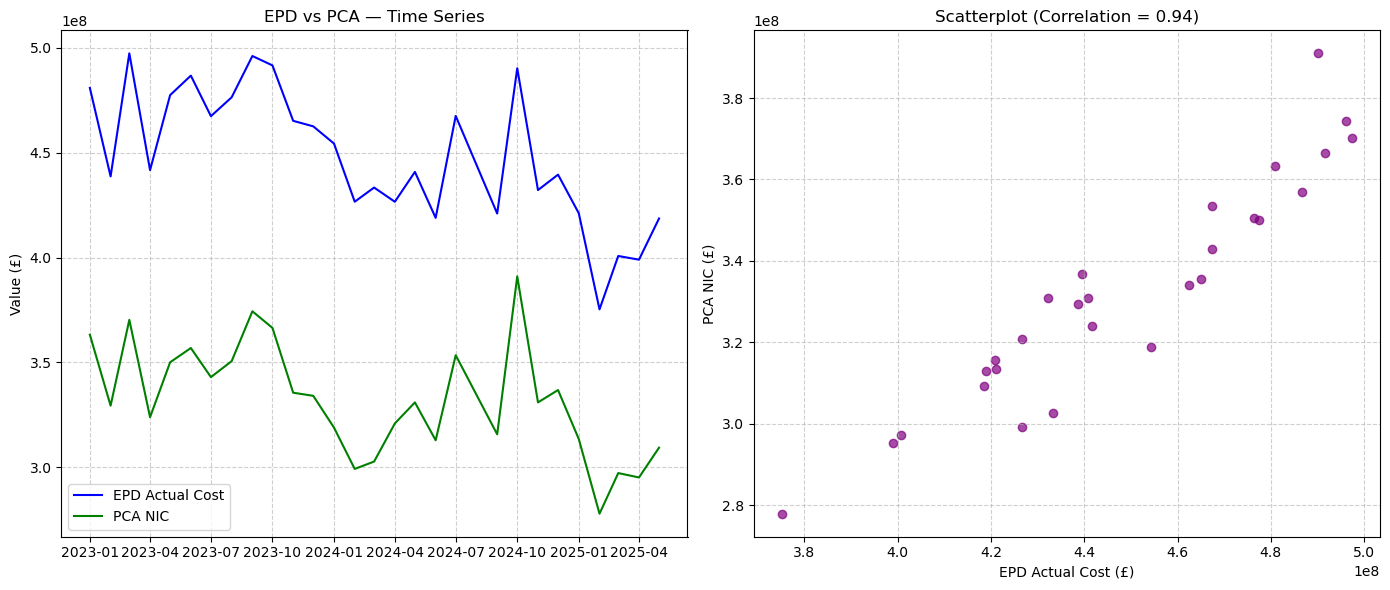

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------- Paths ----------------
BASE = Path("/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData")
EPD_PATH  = BASE / "EPD_Processed_Data_clean.csv"
PCA_PATH  = BASE / "PCA_Processed_Data_clean.csv"

epd  = pd.read_csv(EPD_PATH, dtype=str, low_memory=False)
pca  = pd.read_csv(PCA_PATH, dtype=str, low_memory=False)

# ---------------- Basic typing ----------------
for df in [epd, pca]:
    df["YEAR_MONTH"] = pd.to_numeric(df["YEAR_MONTH"], errors="coerce")
    for col in ["ACTUAL_COST","NIC"]:
        if col in df.columns: df[col] = pd.to_numeric(df[col], errors="coerce")
    df["YM"] = pd.to_datetime(df["YEAR_MONTH"].astype("Int64").astype(str), format="%Y%m", errors="coerce")

epd_m = epd.groupby("YM")["ACTUAL_COST"].sum()
pca_m = pca.groupby("YM")["NIC"].sum()

# Align on same index
df_corr = pd.concat([epd_m, pca_m], axis=1, join="inner")
df_corr.columns = ["EPD_ActualCost","PCA_NIC"]

# Correlation
corr_val = df_corr.corr().iloc[0,1]
print(f"Pearson correlation between EPD Actual Cost and PCA NIC: {corr_val:.4f}")

# ---------------- Plots ----------------
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Time-series comparison
axes[0].plot(df_corr.index, df_corr["EPD_ActualCost"], label="EPD Actual Cost", color="blue")
axes[0].plot(df_corr.index, df_corr["PCA_NIC"], label="PCA NIC", color="green")
axes[0].set_title("EPD vs PCA — Time Series")
axes[0].set_ylabel("Value (£)")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.6)

# Scatterplot
axes[1].scatter(df_corr["EPD_ActualCost"], df_corr["PCA_NIC"], alpha=0.7, color="purple")
axes[1].set_title(f"Scatterplot (Correlation = {corr_val:.2f})")
axes[1].set_xlabel("EPD Actual Cost (£)")
axes[1].set_ylabel("PCA NIC (£)")
axes[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

Pearson correlation between EPD Actual Cost and SCMD Actual Cost: -0.4515


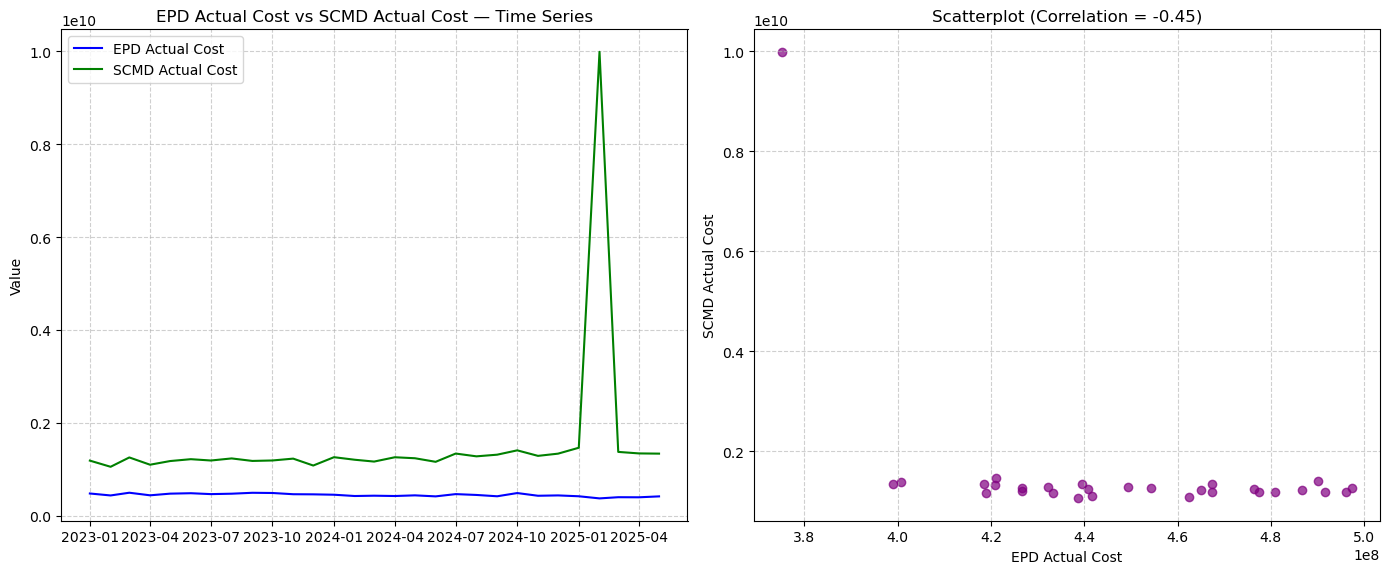

Pearson correlation between EPD Total Quantity and SCMD Total Quantity: 0.3565


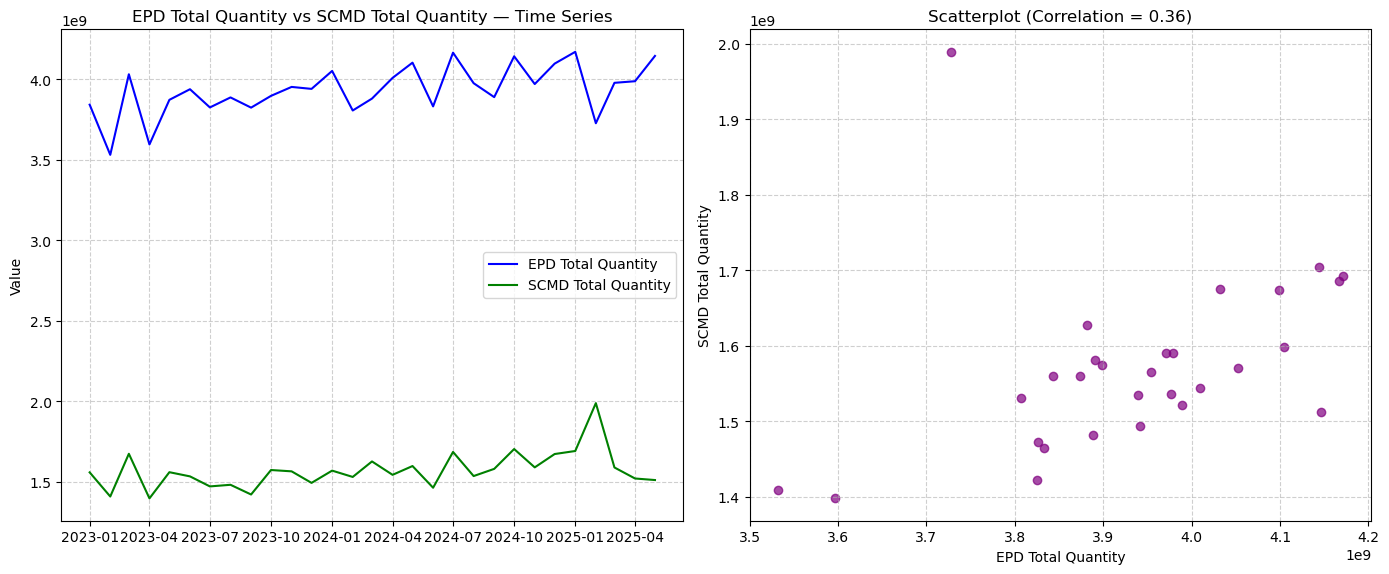

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------- Paths ----------------
BASE = Path("/Users/arunkumarbalaraman/uk_drug_shoratages/ProcessedData")
EPD_PATH  = BASE / "EPD_Processed_Data_clean.csv"
SCMD_PATH = BASE / "SCMD_Processed_Data_clean.csv"

epd  = pd.read_csv(EPD_PATH, dtype=str, low_memory=False)
scmd = pd.read_csv(SCMD_PATH, dtype=str, low_memory=False)

# ---------------- Basic typing ----------------
for df in [epd, scmd]:
    df["YEAR_MONTH"] = pd.to_numeric(df["YEAR_MONTH"], errors="coerce")
    for col in ["ACTUAL_COST","TOTAL_QUANTITY"]:
        if col in df.columns: df[col] = pd.to_numeric(df[col], errors="coerce")
    df["YM"] = pd.to_datetime(df["YEAR_MONTH"].astype("Int64").astype(str), format="%Y%m", errors="coerce")

# Aggregate monthly
epd_cost = epd.groupby("YM")["ACTUAL_COST"].sum()
scmd_cost = scmd.groupby("YM")["ACTUAL_COST"].sum()

epd_qty = epd.groupby("YM")["TOTAL_QUANTITY"].sum()
scmd_qty = scmd.groupby("YM")["TOTAL_QUANTITY"].sum()

# ---- Function for correlation analysis ----
def correlation_analysis(series1, series2, label1, label2):
    df_corr = pd.concat([series1, series2], axis=1, join="inner")
    df_corr.columns = [label1, label2]
    corr_val = df_corr.corr().iloc[0,1]

    print(f"Pearson correlation between {label1} and {label2}: {corr_val:.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(14,6))

    # Time series
    axes[0].plot(df_corr.index, df_corr[label1], label=label1, color="blue")
    axes[0].plot(df_corr.index, df_corr[label2], label=label2, color="green")
    axes[0].set_title(f"{label1} vs {label2} — Time Series")
    axes[0].set_ylabel("Value")
    axes[0].legend()
    axes[0].grid(True, linestyle="--", alpha=0.6)

    # Scatterplot
    axes[1].scatter(df_corr[label1], df_corr[label2], alpha=0.7, color="purple")
    axes[1].set_title(f"Scatterplot (Correlation = {corr_val:.2f})")
    axes[1].set_xlabel(label1)
    axes[1].set_ylabel(label2)
    axes[1].grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

# ---- Run comparisons ----
correlation_analysis(epd_cost, scmd_cost, "EPD Actual Cost", "SCMD Actual Cost")
correlation_analysis(epd_qty,  scmd_qty,  "EPD Total Quantity", "SCMD Total Quantity")